### Calculate basin ET based on the water balance equation
#### ET = P - dTWS - runoff
#### runoff: from USGS station data

#### Snake river basin, runoff = Snake river runoff (13334300) + Clearwater river runoff (13342500). Unit:cubic feet per second

In [163]:
def read_runoff(filepath): #default setting: from the line 35, read data from 2000-01 to 2023-12
    import numpy as np
    import pandas as pd
    
    # Skip the first 35 lines
    df = pd.read_csv(filepath, skiprows=35,delimiter="\t")
    df.drop(index=0,inplace=True)

    # Extract the period from 2000-02 to 2023-12
    df['year_nu'] = df['year_nu'].astype(int)
    df['month_nu'] = df['month_nu'].astype(int)
    df['mean_va'] = df['mean_va'].astype(float)
    df = df[df['year_nu']>1999]
    df = df[df['year_nu']<2024]

    # Generate the time series
    dates = pd.to_datetime([f"{year}-{month:02d}-01" for year, month in zip(df['year_nu'], df['month_nu'])])
    values = [value for value in df['mean_va']]
    runoff = pd.Series(data=values, index=dates)
    return runoff


def convert_unit(series, area):#from cubic feet per second to mm per month, need to provide the area of the basin (mm^2)
    new_series = series
    for i in range(len(series)):
        new_series.iloc[i] = (series.iloc[i]*28316846.592/area)*3600*24*series.index[i].daysinmonth
    return new_series

def read_basin(filepath):
    from geopandas import GeoDataFrame, GeoSeries
    from shapely.geometry import Point, Polygon
    import geopandas
    import numpy as np
    df = geopandas.read_file(filepath) # This is similar to shapefile, and you can load it into GIS softwares. 
    # stationbasins.geojson is a file you can get from GRDC when you download the stream gauging data. 
    # This file contains the basin boundary that drains to the gauging station. 

    lon, lat = -179.875 + np.arange(1440)*0.25, 89.875 - np.arange(720)*0.25
    llon, llat = np.meshgrid(lon,lat)
    flon, flat = llon.flatten(), llat.flatten()
    pts = GeoSeries([Point(x,y) for x,y in zip(flon,flat)])
    in_map = np.array([pts.within(geom) for geom in df.geometry])

    allbasinmask = np.zeros((360,720))

    for i in range(len(in_map)):
    
        basinmask = in_map[i,:].reshape(720,1440).astype(int)
        basinmask = basinmask.reshape(360,2,720,2)
        basinmask = np.sum(np.sum(basinmask,axis=1),axis=-1)
        basinmask[basinmask>1] = 1
        allbasinmask = allbasinmask+basinmask
    return allbasinmask

def cal_ds_error(allbasinmask):
    # Calculate the area-weighted averaged TWS in a basin    
    var1= np.tile(area_weights[allbasinmask==1],(var_TWS.shape[0],1))
    var2 = var_TWS[:,allbasinmask==1]
    var1[np.isnan(var2)]=np.nan
    mask_average = np.nansum(var1*var2,axis=1)/np.nansum(var1,axis=1)
     
    # Calculate the area-weighted averaged TWS-error in a basin   
    var3= np.tile(area_weights[allbasinmask==1],(uncertainty.shape[0],1))
    var4 = uncertainty[:,allbasinmask==1]
    var3[np.isnan(var4)]=np.nan


    #mascon_uncertainty = np.sqrt(np.nansum((var3**2)*(var4**2),axis=1)/np.nansum(var3,axis=1)**2)
    var5 = mascon*allbasinmask
    var5 = var5.filled(np.nan)
    new_var5 = var5.reshape((360*720))
    
    mascon_uncertainty = np.zeros((uncertainty.shape[0]))
    for j in range(var_TWS.shape[0]):
        temp = 0
        for i in list(set(new_var5[:])):
            if i==0:
                continue
            temp = temp+((np.sum(area_weights[var5==i])**2)*(np.mean(uncertainty[j,var5==i])**2))  
        mascon_uncertainty[j] = np.sqrt(temp/(np.nansum(var3[j,:])**2))

    mask_average = pd.Series(mask_average, date)
    #print(mask_average)
    mask_average = mask_average.resample('MS').mean().interpolate('linear',limit=3,limit_area='inside')
    #print(mask_average)

    mascon_uncertainty = pd.Series(mascon_uncertainty, date)
    mascon_uncertainty = mascon_uncertainty.resample('MS').mean().interpolate('linear',limit=3,limit_area='inside')
    ds,ds_error1 = central_diff(mask_average,mascon_uncertainty)
    return ds,ds_error1


def central_diff(series,error):
    ds = (np.array(series[2:]) - np.array(series[0:-2]))/2
    #print(np.array(series[2:]),np.array(series[0:-2]))
    
    ds = pd.Series(ds,index = series.index[1:-1])
    print(ds,series.index)
    error1 = np.sqrt(np.array(error[2:])**2+np.array(error[0:-2])**2)/2
    error1 = pd.Series(error1,index=error.index[1:-1])
    return ds,error1



def cal_pre_error(allbasinmask):
    pre_date = pd.date_range('2000-1-1','2023-12-1',freq='MS')
    var1= np.tile(area_weights[allbasinmask==1],(pre.shape[0],1))
    var2 = pre[:,allbasinmask==1]
    var1[np.isnan(var2)]=np.nan
    pre_average = np.nansum(var1*var2,axis=1)/np.nansum(var1,axis=1)

    var3= np.tile(area_weights[allbasinmask==1],(pre_uncertain.shape[0],1))
    var4 = pre_uncertain[:,allbasinmask==1]
    var3[np.isnan(var4)]=np.nan

    uncertainty_pre_average = np.sqrt(np.nansum((var3**2)*(var4**2),axis=1)/np.nansum(var3,axis=1)**2)

    pre_average = pd.Series(pre_average, pre_date)
    pre_error = pd.Series(uncertainty_pre_average, pre_date)
    return pre_average,pre_error


def cal_et_error(pre_basin,pre_error,ds_basin,ds_error,runoff_basin,runoff_error):
    pre_basin=pre_basin.rolling(window=3, center=True).mean()
    runoff_basin = runoff_basin.rolling(window=3, center=True).mean()
    ET = pre_basin - ds_basin- runoff_basin
    ET_error = np.sqrt(ds_error**2+pre_error**2+runoff_error**2)
    return ET, ET_error

In [155]:
date

DatetimeIndex(['2002-04-17 12:00:00', '2002-05-10 12:00:00',
               '2002-08-16 12:00:00', '2002-09-16 00:00:00',
               '2002-10-16 12:00:00', '2002-11-16 00:00:00',
               '2002-12-16 12:00:00', '2003-01-16 12:00:00',
               '2003-02-15 00:00:00', '2003-03-16 12:00:00',
               ...
               '2024-01-16 12:00:00', '2024-02-15 12:00:00',
               '2024-03-16 12:00:00', '2024-04-16 00:00:00',
               '2024-05-16 12:00:00', '2024-06-16 00:00:00',
               '2024-07-16 12:00:00', '2024-08-16 12:00:00',
               '2024-09-16 00:00:00', '2024-10-16 12:00:00'],
              dtype='datetime64[ns]', length=238, freq=None)

In [154]:
tstindex = pd.date_range(start='2000-1',end='2001-1',freq='MS')
tstts = pd.Series(np.arange(13),index=tstindex)
tsterr = pd.Series(np.arange(13)+2,index=tstindex)
central_diff(tstts,tsterr)
tstts.index[1:-1]

2000-02-01    1.0
2000-03-01    1.0
2000-04-01    1.0
2000-05-01    1.0
2000-06-01    1.0
2000-07-01    1.0
2000-08-01    1.0
2000-09-01    1.0
2000-10-01    1.0
2000-11-01    1.0
2000-12-01    1.0
Freq: MS, dtype: float64 DatetimeIndex(['2000-01-01', '2000-02-01', '2000-03-01', '2000-04-01',
               '2000-05-01', '2000-06-01', '2000-07-01', '2000-08-01',
               '2000-09-01', '2000-10-01', '2000-11-01', '2000-12-01',
               '2001-01-01'],
              dtype='datetime64[ns]', freq='MS')


DatetimeIndex(['2000-02-01', '2000-03-01', '2000-04-01', '2000-05-01',
               '2000-06-01', '2000-07-01', '2000-08-01', '2000-09-01',
               '2000-10-01', '2000-11-01', '2000-12-01'],
              dtype='datetime64[ns]', freq='MS')

In [126]:
def resample(original_data):
    import numpy as np
    from scipy.interpolate import RegularGridInterpolator
    tmp_lon = np.linspace(-180,180,original_data.shape[2])
    tmp_lat = np.linspace(90,-90,original_data.shape[1])
    new_data = np.zeros((original_data.shape[0],360,720))
    for i in range(new_data.shape[0]):
    
        # Target dimensions
        new_x = np.linspace(-180, 180, 720)
        new_y = np.linspace(90, -90, 360)

        # Interpolation function
        interpolator = RegularGridInterpolator((tmp_lon, tmp_lat), original_data[i,:,:].reshape(original_data.shape[1],original_data.shape[2]).T,bounds_error=False,fill_value=None )

        X_new, Y_new = np.meshgrid(new_x, new_y)
        new_points = np.array([X_new.ravel(), Y_new.ravel()]).T

        # Reshape the interpolated values back into the new grid shape
        resized_array = interpolator(new_points).reshape((360,720))
        # New array with target dimensions
        new_data[i,:,:] = resized_array

    return new_data



In [161]:
# read .nc data
import numpy as np
import netCDF4
import pandas as pd
import matplotlib.pyplot as plt
dataset = netCDF4.Dataset('E:/01Project/04ET_assessment/GRCTellus.JPL.200204_202410.GLO.RL06.3M.MSCNv04CRI.nc') 

# shift the data for right display
tmp_lat = dataset.variables['lat'][:]
tmp_lon = dataset.variables['lon'][:]
tmp_TWS = dataset.variables['lwe_thickness'][:]
uncertainty = dataset.variables['uncertainty'][:]
mascon = dataset.variables['mascon_ID'][:]
var_lat = np.flip(tmp_lat) # from [-90,90] to [90,-90]
var_lon = tmp_lon - 180. # from [0,360] to [-180,180]
var_TWS = np.roll(np.flip(tmp_TWS,axis=1),360, axis=2)*10 #from cm to mm
uncertainty = np.roll(np.flip(uncertainty,axis=1),360, axis=2)*10
mascon = np.roll(np.flip(mascon,axis=0),360,axis=1)
date = pd.to_datetime(dataset.variables['time'][:],unit='D',origin=pd.Timestamp('2002-1-1'))

# Get the weighted area in each global cell
area_weights = np.zeros((len(var_lat),len(var_lon))) # This is set to account for different areal extent for each grid cell.
radius = 6371 # km
dlat, dlon = 0.5, 0.5 # each grid cell size is 0.5 degree on the latitude and longitude directions.  
for i in range(len(var_lat)):
    for j in range(len(var_lon)):
        area_weights[i,j] = radius**2*np.cos(np.radians(var_lat[i]))*np.radians(dlat)*np.radians(dlon) #dS = r² sinθ dθ dφ , θ is 90-lat       

## Read the GPCP precipitation and error dataset, from the unit (mm/day) to (mm/month)
import netCDF4
pre = np.zeros((288,360,720))*np.nan
pre_uncertain = np.zeros((288,360,720))*np.nan
pre_date = pd.date_range('2000-1-1','2023-12-1',freq='MS')
count = 0
for year in range(2000,2024):
    for mon in range(1,13):
        pre[count,:,:] = netCDF4.Dataset('E:/01Project/01ET/01Data/01GPCP/GPCPMON_L3_{0:04d}{1:02d}_V3.2.nc4'.format(year,mon))['sat_gauge_precip'][:]\
                                *pre_date[count].daysinmonth
        count = count + 1

count = 0
for year in range(2000,2024):
    for mon in range(1,13):
        pre_uncertain[count,:,:] = netCDF4.Dataset('E:/01Project/01ET/01Data/01GPCP/GPCPMON_L3_{0:04d}{1:02d}_V3.2.nc4'.format(year,mon))['sat_gauge_error'][:]\
                                *pre_date[count].daysinmonth
        count = count + 1

In [81]:
## Read the GLEAM ET (mm/month)
import netCDF4
gleam= np.zeros((264,360,720))*np.nan

gleam_date = pd.date_range('2002-1-1','2023-12-1',freq='MS')
count = 0
for year in range(2002,2024):
    gleam[count:count+12,:,:] = resample(netCDF4.Dataset('E:/01Project/04ET_assessment/07GLEAM_ET/E_{:04d}_GLEAM_v4.2a_MO.nc'.format(year)).variables['E'][:])
    count = count + 12

In [90]:
def read_gleam(allbasinmask):
    # Calculate the area-weighted averaged TWS in a basin    
    var1= np.tile(area_weights[allbasinmask==1],(gleam.shape[0],1))
    var2 = gleam[:,allbasinmask==1]
    var1[np.isnan(var2)]=np.nan
    mask_average = np.nansum(var1*var2,axis=1)/np.nansum(var1,axis=1)
    mask_average = pd.Series(mask_average, gleam_date).rolling(window=3, center=True).mean()

    return mask_average

### Read Snake river basin

2002-05-01   -34.810880
2002-06-01   -54.643290
2002-07-01   -54.643290
2002-08-01   -36.800812
2002-09-01   -19.668779
                ...    
2024-05-01   -34.032015
2024-06-01   -72.181925
2024-07-01   -56.323648
2024-08-01   -20.470198
2024-09-01   -24.822336
Freq: MS, Length: 269, dtype: float64 DatetimeIndex(['2002-04-01', '2002-05-01', '2002-06-01', '2002-07-01',
               '2002-08-01', '2002-09-01', '2002-10-01', '2002-11-01',
               '2002-12-01', '2003-01-01',
               ...
               '2024-01-01', '2024-02-01', '2024-03-01', '2024-04-01',
               '2024-05-01', '2024-06-01', '2024-07-01', '2024-08-01',
               '2024-09-01', '2024-10-01'],
              dtype='datetime64[ns]', length=271, freq='MS')
2000-01-01          NaN
2000-02-01          NaN
2000-03-01          NaN
2000-04-01          NaN
2000-05-01          NaN
2000-06-01          NaN
2000-07-01          NaN
2000-08-01          NaN
2000-09-01          NaN
2000-10-01          NaN
2000-11

Text(0.5, 1.0, 'Snake river basin ET and uncertainty')

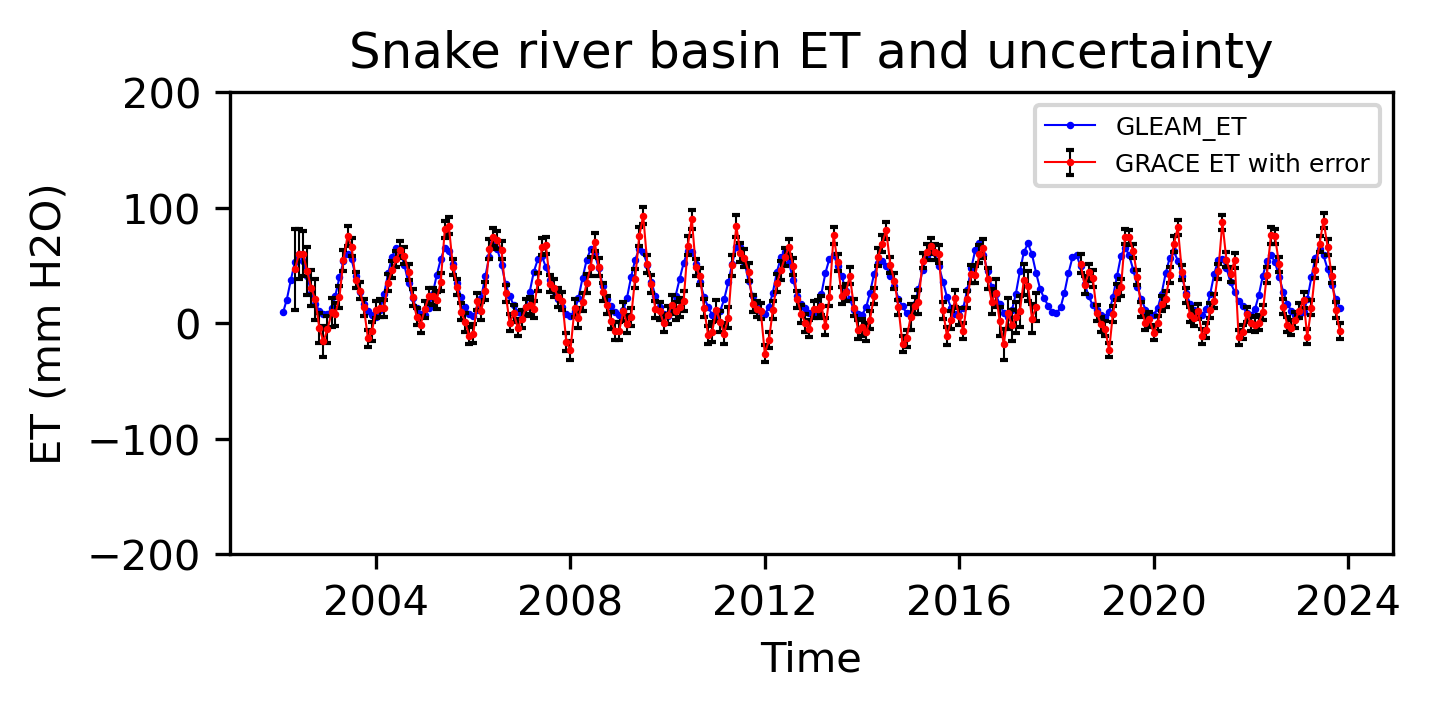

In [189]:
# read the runoff and the basin boundary
runoff_snake = read_runoff("E:/01Project/04ET_assessment/01USGS_runoff/USGS_13334300.txt")
runoff_clearwater = read_runoff("E:/01Project/04ET_assessment/01USGS_runoff/USGS_13342500.txt")
runoff_total = runoff_snake+runoff_clearwater
allbasinmask = read_basin("E:/01Project/04ET_assessment/04Basin_Boundary/Snake_river.shp")

# calculate the runoff
sum_area = np.sum(np.sum((area_weights[allbasinmask==1]))*1000000000000) #convert the unit from km^2 to mm^2
runoff_basin = convert_unit(runoff_total,sum_area)
runoff_error = 0.1*runoff_basin
# calculate the ds, pre, and ET
ds_basin,ds_error = cal_ds_error(allbasinmask)
pre_basin,pre_error = cal_pre_error(allbasinmask)
ET_basin,ET_error = cal_et_error(pre_basin,pre_error,ds_basin,ds_error,runoff_basin,runoff_error)
print(ET_basin.head(40))

GLEAM_ET = read_gleam(allbasinmask)

# plot the baisn ET and error
plt.figure(figsize=(5,2),dpi=300)
plt.ylim(-200,200)
yerr = np.array(ET_error)
plt.plot(GLEAM_ET, '-ob',linewidth=0.5,markersize =0.8,label='GLEAM_ET')
plt.errorbar(ET_basin.index, np.array(ET_basin), yerr=yerr,fmt='-or',linewidth=0.5,markersize =0.8, elinewidth=0.5,ecolor='k',capsize=1, label='GRACE ET with error')
plt.xlabel('Time')
plt.legend(fontsize=6)

plt.ylabel('ET (mm H2O)')
plt.title('Snake river basin ET and uncertainty')

In [157]:
import pdb
pdb.runcall(cal_ds_error,allbasinmask)

> c:\users\yannizhao\appdata\local\temp\ipykernel_21628\1428654258.py(57)cal_ds_error()



ipdb>  l


     52         allbasinmask = allbasinmask+basinmask
     53     return allbasinmask
     54 
     55 def cal_ds_error(allbasinmask):
     56     # Calculate the area-weighted averaged TWS in a basin
---> 57     var1= np.tile(area_weights[allbasinmask==1],(var_TWS.shape[0],1))
     58     var2 = var_TWS[:,allbasinmask==1]
     59     var1[np.isnan(var2)]=np.nan
     60     mask_average = np.nansum(var1*var2,axis=1)/np.nansum(var1,axis=1)
     61 
     62     # Calculate the area-weighted averaged TWS-error in a basin



ipdb>  n


> c:\users\yannizhao\appdata\local\temp\ipykernel_21628\1428654258.py(58)cal_ds_error()



ipdb>  n


> c:\users\yannizhao\appdata\local\temp\ipykernel_21628\1428654258.py(59)cal_ds_error()



ipdb>  n


> c:\users\yannizhao\appdata\local\temp\ipykernel_21628\1428654258.py(60)cal_ds_error()



ipdb>  n


> c:\users\yannizhao\appdata\local\temp\ipykernel_21628\1428654258.py(63)cal_ds_error()



ipdb>  l


     58     var2 = var_TWS[:,allbasinmask==1]
     59     var1[np.isnan(var2)]=np.nan
     60     mask_average = np.nansum(var1*var2,axis=1)/np.nansum(var1,axis=1)
     61 
     62     # Calculate the area-weighted averaged TWS-error in a basin
---> 63     var3= np.tile(area_weights[allbasinmask==1],(uncertainty.shape[0],1))
     64     var4 = uncertainty[:,allbasinmask==1]
     65     var3[np.isnan(var4)]=np.nan
     66 
     67 
     68     #mascon_uncertainty = np.sqrt(np.nansum((var3**2)*(var4**2),axis=1)/np.nansum(var3,axis=1)**2)



ipdb>  n


> c:\users\yannizhao\appdata\local\temp\ipykernel_21628\1428654258.py(64)cal_ds_error()



ipdb>  n


> c:\users\yannizhao\appdata\local\temp\ipykernel_21628\1428654258.py(65)cal_ds_error()



ipdb>  n


> c:\users\yannizhao\appdata\local\temp\ipykernel_21628\1428654258.py(69)cal_ds_error()



ipdb>  n


> c:\users\yannizhao\appdata\local\temp\ipykernel_21628\1428654258.py(70)cal_ds_error()



ipdb>  n


> c:\users\yannizhao\appdata\local\temp\ipykernel_21628\1428654258.py(71)cal_ds_error()



ipdb>  n


> c:\users\yannizhao\appdata\local\temp\ipykernel_21628\1428654258.py(73)cal_ds_error()



ipdb>  l


     68     #mascon_uncertainty = np.sqrt(np.nansum((var3**2)*(var4**2),axis=1)/np.nansum(var3,axis=1)**2)
     69     var5 = mascon*allbasinmask
     70     var5 = var5.filled(np.nan)
     71     new_var5 = var5.reshape((360*720))
     72 
---> 73     mascon_uncertainty = np.zeros((uncertainty.shape[0]))
     74     for j in range(var_TWS.shape[0]):
     75         temp = 0
     76         for i in list(set(new_var5[:])):
     77             if i==0:
     78                 continue



ipdb>  n


> c:\users\yannizhao\appdata\local\temp\ipykernel_21628\1428654258.py(74)cal_ds_error()



ipdb>  n


> c:\users\yannizhao\appdata\local\temp\ipykernel_21628\1428654258.py(75)cal_ds_error()



ipdb>  n


> c:\users\yannizhao\appdata\local\temp\ipykernel_21628\1428654258.py(76)cal_ds_error()



ipdb>  n


> c:\users\yannizhao\appdata\local\temp\ipykernel_21628\1428654258.py(77)cal_ds_error()



ipdb>  n


> c:\users\yannizhao\appdata\local\temp\ipykernel_21628\1428654258.py(78)cal_ds_error()



ipdb>  n


> c:\users\yannizhao\appdata\local\temp\ipykernel_21628\1428654258.py(76)cal_ds_error()



ipdb>  n


> c:\users\yannizhao\appdata\local\temp\ipykernel_21628\1428654258.py(77)cal_ds_error()



ipdb>  l


     72 
     73     mascon_uncertainty = np.zeros((uncertainty.shape[0]))
     74     for j in range(var_TWS.shape[0]):
     75         temp = 0
     76         for i in list(set(new_var5[:])):
---> 77             if i==0:
     78                 continue
     79             temp = temp+((np.sum(area_weights[var5==i])**2)*(np.mean(uncertainty[j,var5==i])**2))
     80         mascon_uncertainty[j] = np.sqrt(temp/(np.nansum(var3[j,:])**2))
     81 
     82     mask_average = pd.Series(mask_average, date)



ipdb>  n


> c:\users\yannizhao\appdata\local\temp\ipykernel_21628\1428654258.py(79)cal_ds_error()



ipdb>  n


> c:\users\yannizhao\appdata\local\temp\ipykernel_21628\1428654258.py(76)cal_ds_error()



ipdb>  n


> c:\users\yannizhao\appdata\local\temp\ipykernel_21628\1428654258.py(77)cal_ds_error()



ipdb>  n


> c:\users\yannizhao\appdata\local\temp\ipykernel_21628\1428654258.py(79)cal_ds_error()



ipdb>  n


> c:\users\yannizhao\appdata\local\temp\ipykernel_21628\1428654258.py(76)cal_ds_error()



ipdb>  n


> c:\users\yannizhao\appdata\local\temp\ipykernel_21628\1428654258.py(77)cal_ds_error()



ipdb>  n


> c:\users\yannizhao\appdata\local\temp\ipykernel_21628\1428654258.py(79)cal_ds_error()



ipdb>  l


     74     for j in range(var_TWS.shape[0]):
     75         temp = 0
     76         for i in list(set(new_var5[:])):
     77             if i==0:
     78                 continue
---> 79             temp = temp+((np.sum(area_weights[var5==i])**2)*(np.mean(uncertainty[j,var5==i])**2))
     80         mascon_uncertainty[j] = np.sqrt(temp/(np.nansum(var3[j,:])**2))
     81 
     82     mask_average = pd.Series(mask_average, date)
     83     print(mask_average)
     84     mask_average = mask_average.resample('MS').mean().interpolate('linear',limit=3,limit_area='inside')



ipdb>  n


> c:\users\yannizhao\appdata\local\temp\ipykernel_21628\1428654258.py(76)cal_ds_error()



ipdb>  n


> c:\users\yannizhao\appdata\local\temp\ipykernel_21628\1428654258.py(77)cal_ds_error()



ipdb>  n


> c:\users\yannizhao\appdata\local\temp\ipykernel_21628\1428654258.py(79)cal_ds_error()



ipdb>  n


> c:\users\yannizhao\appdata\local\temp\ipykernel_21628\1428654258.py(76)cal_ds_error()



ipdb>  n


> c:\users\yannizhao\appdata\local\temp\ipykernel_21628\1428654258.py(77)cal_ds_error()



ipdb>  n


> c:\users\yannizhao\appdata\local\temp\ipykernel_21628\1428654258.py(79)cal_ds_error()



ipdb>  n


> c:\users\yannizhao\appdata\local\temp\ipykernel_21628\1428654258.py(76)cal_ds_error()



ipdb>  l


     71     new_var5 = var5.reshape((360*720))
     72 
     73     mascon_uncertainty = np.zeros((uncertainty.shape[0]))
     74     for j in range(var_TWS.shape[0]):
     75         temp = 0
---> 76         for i in list(set(new_var5[:])):
     77             if i==0:
     78                 continue
     79             temp = temp+((np.sum(area_weights[var5==i])**2)*(np.mean(uncertainty[j,var5==i])**2))
     80         mascon_uncertainty[j] = np.sqrt(temp/(np.nansum(var3[j,:])**2))
     81 



ipdb>  break 81


*** Blank or comment


ipdb>  break 84


*** Line c:\users\yannizhao\appdata\local\temp\ipykernel_21628\1428654258.py:84 does not exist


ipdb>  n


> c:\users\yannizhao\appdata\local\temp\ipykernel_21628\1428654258.py(77)cal_ds_error()



ipdb>  l


     72 
     73     mascon_uncertainty = np.zeros((uncertainty.shape[0]))
     74     for j in range(var_TWS.shape[0]):
     75         temp = 0
     76         for i in list(set(new_var5[:])):
---> 77             if i==0:
     78                 continue
     79             temp = temp+((np.sum(area_weights[var5==i])**2)*(np.mean(uncertainty[j,var5==i])**2))
     80         mascon_uncertainty[j] = np.sqrt(temp/(np.nansum(var3[j,:])**2))
     81 
     82     mask_average = pd.Series(mask_average, date)



ipdb>  mask_average


masked_array(data=[83.80220637806022, 68.8237367339087,
                   -95.10613338919237, -114.06446669437764,
                   -134.44369111451343, -120.15658952206599,
                   -68.20597266273498, -1.6570869153595464,
                   32.724037667819765, 64.48078294046742,
                   91.3269372449481, 86.40467906485969,
                   -56.63968239090398, -111.92826261843454,
                   -114.53446716081983, -145.91624938771523,
                   -105.67994531395281, -43.65588759872346,
                   12.945049658121313, 39.29416005353148,
                   52.72168999477811, 55.23613762832523,
                   31.81886380259958, 19.182756495295227,
                   -24.84091077603822, -67.6209792721041,
                   -96.62148640222578, -88.27407859806387,
                   -79.47273815263735, -27.709318012209867,
                   -14.812875759367172, 3.4139935257944556,
                   -7.452424099251363, 17.553523789595925,

ipdb>  b 86


*** Blank or comment


ipdb>  b 30


*** Line c:\users\yannizhao\appdata\local\temp\ipykernel_21628\1428654258.py:30 does not exist


ipdb>  b 88


*** Line c:\users\yannizhao\appdata\local\temp\ipykernel_21628\1428654258.py:88 does not exist


ipdb>  break 88


*** Line c:\users\yannizhao\appdata\local\temp\ipykernel_21628\1428654258.py:88 does not exist


ipdb>  break 30


*** Line c:\users\yannizhao\appdata\local\temp\ipykernel_21628\1428654258.py:30 does not exist


ipdb>  breakpoint 88


*** SyntaxError: invalid syntax


ipdb>  b 1


*** Line c:\users\yannizhao\appdata\local\temp\ipykernel_21628\1428654258.py:1 does not exist


ipdb>  break 1


*** Line c:\users\yannizhao\appdata\local\temp\ipykernel_21628\1428654258.py:1 does not exist


ipdb>  b 0


End of file


ipdb>  l


     83     print(mask_average)
     84     mask_average = mask_average.resample('MS').mean().interpolate('linear',limit=3,limit_area='inside')
     85     print(mask_average)
     86 
     87     mascon_uncertainty = pd.Series(mascon_uncertainty, date)
     88     mascon_uncertainty = mascon_uncertainty.resample('MS').mean().interpolate('linear',limit=3,limit_area='inside')
     89     ds,ds_error1 = central_diff(mask_average,mascon_uncertainty)
     90     return ds,ds_error1
     91 
     92 
     93 def central_diff(series,error):



ipdb>  


     94     ds = (np.array(series[2:]) - np.array(series[0:-2]))/2
     95     #print(np.array(series[2:]),np.array(series[0:-2]))
     96 
     97     ds = pd.Series(ds,index = series.index[1:-1])
     98     print(ds,series.index)
     99     error1 = np.sqrt(np.array(error[2:])**2+np.array(error[0:-2])**2)/2
    100     error1 = pd.Series(error1,index=error.index[1:-1])
    101     return ds,error1
    102 
    103 
    104 



ipdb>  n


> c:\users\yannizhao\appdata\local\temp\ipykernel_21628\1428654258.py(79)cal_ds_error()



ipdb>  l


     74     for j in range(var_TWS.shape[0]):
     75         temp = 0
     76         for i in list(set(new_var5[:])):
     77             if i==0:
     78                 continue
---> 79             temp = temp+((np.sum(area_weights[var5==i])**2)*(np.mean(uncertainty[j,var5==i])**2))
     80         mascon_uncertainty[j] = np.sqrt(temp/(np.nansum(var3[j,:])**2))
     81 
     82     mask_average = pd.Series(mask_average, date)
     83     print(mask_average)
     84     mask_average = mask_average.resample('MS').mean().interpolate('linear',limit=3,limit_area='inside')



ipdb>  b 84


*** Line c:\users\yannizhao\appdata\local\temp\ipykernel_21628\1428654258.py:84 does not exist


ipdb>  b 55


*** Line c:\users\yannizhao\appdata\local\temp\ipykernel_21628\1428654258.py:55 does not exist


ipdb>  b 56


*** Blank or comment


ipdb>  l


     85     print(mask_average)
     86 
     87     mascon_uncertainty = pd.Series(mascon_uncertainty, date)
     88     mascon_uncertainty = mascon_uncertainty.resample('MS').mean().interpolate('linear',limit=3,limit_area='inside')
     89     ds,ds_error1 = central_diff(mask_average,mascon_uncertainty)
     90     return ds,ds_error1
     91 
     92 
     93 def central_diff(series,error):
     94     ds = (np.array(series[2:]) - np.array(series[0:-2]))/2
     95     #print(np.array(series[2:]),np.array(series[0:-2]))



ipdb>  n


> c:\users\yannizhao\appdata\local\temp\ipykernel_21628\1428654258.py(76)cal_ds_error()



ipdb>  l


     71     new_var5 = var5.reshape((360*720))
     72 
     73     mascon_uncertainty = np.zeros((uncertainty.shape[0]))
     74     for j in range(var_TWS.shape[0]):
     75         temp = 0
---> 76         for i in list(set(new_var5[:])):
     77             if i==0:
     78                 continue
     79             temp = temp+((np.sum(area_weights[var5==i])**2)*(np.mean(uncertainty[j,var5==i])**2))
     80         mascon_uncertainty[j] = np.sqrt(temp/(np.nansum(var3[j,:])**2))
     81 



ipdb>  n


> c:\users\yannizhao\appdata\local\temp\ipykernel_21628\1428654258.py(77)cal_ds_error()



ipdb>  n


> c:\users\yannizhao\appdata\local\temp\ipykernel_21628\1428654258.py(79)cal_ds_error()



ipdb>  n


> c:\users\yannizhao\appdata\local\temp\ipykernel_21628\1428654258.py(76)cal_ds_error()



ipdb>  n


> c:\users\yannizhao\appdata\local\temp\ipykernel_21628\1428654258.py(80)cal_ds_error()



ipdb>  l


     75         temp = 0
     76         for i in list(set(new_var5[:])):
     77             if i==0:
     78                 continue
     79             temp = temp+((np.sum(area_weights[var5==i])**2)*(np.mean(uncertainty[j,var5==i])**2))
---> 80         mascon_uncertainty[j] = np.sqrt(temp/(np.nansum(var3[j,:])**2))
     81 
     82     mask_average = pd.Series(mask_average, date)
     83     print(mask_average)
     84     mask_average = mask_average.resample('MS').mean().interpolate('linear',limit=3,limit_area='inside')
     85     print(mask_average)



ipdb>  n


> c:\users\yannizhao\appdata\local\temp\ipykernel_21628\1428654258.py(74)cal_ds_error()



ipdb>  n


> c:\users\yannizhao\appdata\local\temp\ipykernel_21628\1428654258.py(75)cal_ds_error()



ipdb>  n


> c:\users\yannizhao\appdata\local\temp\ipykernel_21628\1428654258.py(76)cal_ds_error()



ipdb>  n


> c:\users\yannizhao\appdata\local\temp\ipykernel_21628\1428654258.py(77)cal_ds_error()



ipdb>  n


> c:\users\yannizhao\appdata\local\temp\ipykernel_21628\1428654258.py(78)cal_ds_error()



ipdb>  l


     73     mascon_uncertainty = np.zeros((uncertainty.shape[0]))
     74     for j in range(var_TWS.shape[0]):
     75         temp = 0
     76         for i in list(set(new_var5[:])):
     77             if i==0:
---> 78                 continue
     79             temp = temp+((np.sum(area_weights[var5==i])**2)*(np.mean(uncertainty[j,var5==i])**2))
     80         mascon_uncertainty[j] = np.sqrt(temp/(np.nansum(var3[j,:])**2))
     81 
     82     mask_average = pd.Series(mask_average, date)
     83     print(mask_average)

--KeyboardInterrupt--

KeyboardInterrupt: Interrupted by user
2002-04-17 12:00:00     83.802206
2002-05-10 12:00:00     68.823737
2002-08-16 12:00:00    -95.106133
2002-09-16 00:00:00   -114.064467
2002-10-16 12:00:00   -134.443691
                          ...    
2024-06-16 00:00:00     66.279372
2024-07-16 12:00:00    -28.820752
2024-08-16 12:00:00    -46.367923
2024-09-16 00:00:00    -69.761148
2024-10-16 12:00:00    -96.012595
Length: 238, dtype: float64
200

(2002-05-01   -34.810880
 2002-06-01   -54.643290
 2002-07-01   -54.643290
 2002-08-01   -36.800812
 2002-09-01   -19.668779
                 ...    
 2024-05-01   -34.032015
 2024-06-01   -72.181925
 2024-07-01   -56.323648
 2024-08-01   -20.470198
 2024-09-01   -24.822336
 Freq: MS, Length: 269, dtype: float64,
 2002-05-01    34.852896
 2002-06-01    21.382902
 2002-07-01    19.470822
 2002-08-01    20.560104
 2002-09-01    15.375644
                 ...    
 2024-05-01     9.826092
 2024-06-01    11.735048
 2024-07-01    13.955297
 2024-08-01    17.217875
 2024-09-01    21.025241
 Freq: MS, Length: 269, dtype: float64)

In [159]:
conda install xeus-python

error: bad escape \P at position 28

In [133]:
ET_basin,ET_error = cal_et_error(pre_basin,pre_error,ds_basin,ds_error,runoff_basin,runoff_error)
print(ET_basin)

2000-01-01   NaN
2000-02-01   NaN
2000-03-01   NaN
2000-04-01   NaN
2000-05-01   NaN
              ..
2024-05-01   NaN
2024-06-01   NaN
2024-07-01   NaN
2024-08-01   NaN
2024-09-01   NaN
Length: 297, dtype: float64


In [191]:
ds_basin

2002-05-01   -34.810880
2002-06-01   -54.643290
2002-07-01   -54.643290
2002-08-01   -36.800812
2002-09-01   -19.668779
                ...    
2024-05-01   -34.032015
2024-06-01   -72.181925
2024-07-01   -56.323648
2024-08-01   -20.470198
2024-09-01   -24.822336
Freq: MS, Length: 269, dtype: float64

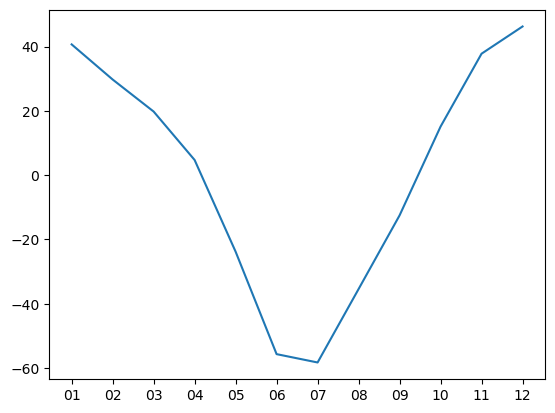

In [190]:
a,b = interannual(ds_basin)
plt.plot(b)

In [188]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def interannual(ts):
    rshp = ts.groupby([ts.index.year,ts.index.strftime('%m')],dropna=False).mean().unstack()
    annual = rshp.mean(axis=1,skipna=True)
    climatology = rshp.mean(axis=0,skipna=True)
    deseason = (rshp - climatology).T.unstack()
    start_yr = ts.index[0].year
    end_yr = ts.index[-1].year
    deseason = pd.Series(deseason.values,index=pd.date_range(start=pd.to_datetime('{0:04d}-1-1'.format(start_yr)), \
                                                    periods=len(deseason.values), freq='MS')) 
    return deseason,climatology

In [167]:
ET_uncertian1 = pd.DataFrame({'Date':ET_error.index,'ET_error':np.array(ET_error)})
ET1 = pd.DataFrame({'Date':ET_basin.index,'ET':np.array(ET_basin)})
ds1 = pd.DataFrame({'Date':ds_basin.index,'dTWS':np.array(ds_basin)})
ds_error1 = pd.DataFrame({'Date':ds_error.index,'dTWS_error':np.array(ds_error)})
pre_average1 = pd.DataFrame({'Date':pre_basin.index,'PRE':np.array(pre_basin)})
pre_error1 = pd.DataFrame({'Date':pre_error.index,'PRE_error':np.array(pre_error)})
runnoff_mm1 = pd.DataFrame({'Date':runoff_basin.index,'Runoff':np.array(runoff_basin)})
runnoff_mm2 = pd.DataFrame({'Date':runoff_error.index,'Runoff_error':np.array(runoff_error)})
#merge_df = pd.merge(ET1, ET_uncertian1,ds1,ds_error1,pre_average1,pre_error1,runnoff_mm1, on='Date')
merge_df = pd.merge(ET1, ET_uncertian1, on='Date')
merge_df = pd.merge(merge_df,pre_average1, on='Date')
merge_df = pd.merge(merge_df,pre_error1, on='Date')
merge_df = pd.merge(merge_df,ds1, on='Date')
merge_df = pd.merge(merge_df,ds_error1, on='Date')
merge_df = pd.merge(merge_df,runnoff_mm1, on='Date')
merge_df = pd.merge(merge_df,runnoff_mm2, on='Date')
print(merge_df)
merge_df.to_excel("E:/01Project/04ET_assessment/05GRACE-based_ET/Snake_river_ET.xlsx", index=False)

          Date         ET   ET_error        PRE  PRE_error       dTWS  \
0   2002-05-01  46.509410  34.917107  25.804485   0.322158 -34.810880   
1   2002-06-01  60.147912  21.508013  31.704251   0.337903 -54.643290   
2   2002-07-01  59.988927  19.496630  12.630556   0.217708 -54.643290   
3   2002-08-01  45.165717  20.575833  12.140619   0.221638 -36.800812   
4   2002-09-01  30.277811  15.387559  23.275242   0.267749 -19.668779   
..         ...        ...        ...        ...        ...        ...   
255 2023-08-01  66.019023   6.587147  42.579855   1.222016 -45.636423   
256 2023-09-01  40.987565   6.566503  34.722585   1.091956 -11.015985   
257 2023-10-01  11.369030   6.780886  30.258365   1.020645  20.744096   
258 2023-11-01  -6.901507   7.090825  47.059515   1.289828  41.833119   
259 2023-12-01        NaN   7.619064  42.922614   1.279465  52.100356   

     dTWS_error     Runoff  Runoff_error  
0     34.852896  20.919364      2.091936  
1     21.382902  22.917053      2.291

In [93]:
GLEAM_ET1 = pd.DataFrame({'Date':GLEAM_ET.index,'GLEAM_ET':np.array(GLEAM_ET)})
GLEAM_ET1.to_excel("E:/01Project/04ET_assessment/07GLEAM_ET_excel/Snake_river_GLEAMET.xlsx", index=False)

### Read the Columbia river basin

2002-05-01   -37.460013
2002-06-01   -71.848482
2002-07-01   -71.848482
2002-08-01   -50.225877
2002-09-01   -30.599784
                ...    
2024-05-01   -34.398569
2024-06-01   -71.943269
2024-07-01   -74.867647
2024-08-01   -35.230065
2024-09-01   -22.452485
Freq: MS, Length: 269, dtype: float64 DatetimeIndex(['2002-04-01', '2002-05-01', '2002-06-01', '2002-07-01',
               '2002-08-01', '2002-09-01', '2002-10-01', '2002-11-01',
               '2002-12-01', '2003-01-01',
               ...
               '2024-01-01', '2024-02-01', '2024-03-01', '2024-04-01',
               '2024-05-01', '2024-06-01', '2024-07-01', '2024-08-01',
               '2024-09-01', '2024-10-01'],
              dtype='datetime64[ns]', length=271, freq='MS')
2000-01-01   NaN
2000-02-01   NaN
2000-03-01   NaN
2000-04-01   NaN
2000-05-01   NaN
              ..
2024-05-01   NaN
2024-06-01   NaN
2024-07-01   NaN
2024-08-01   NaN
2024-09-01   NaN
Length: 297, dtype: float64


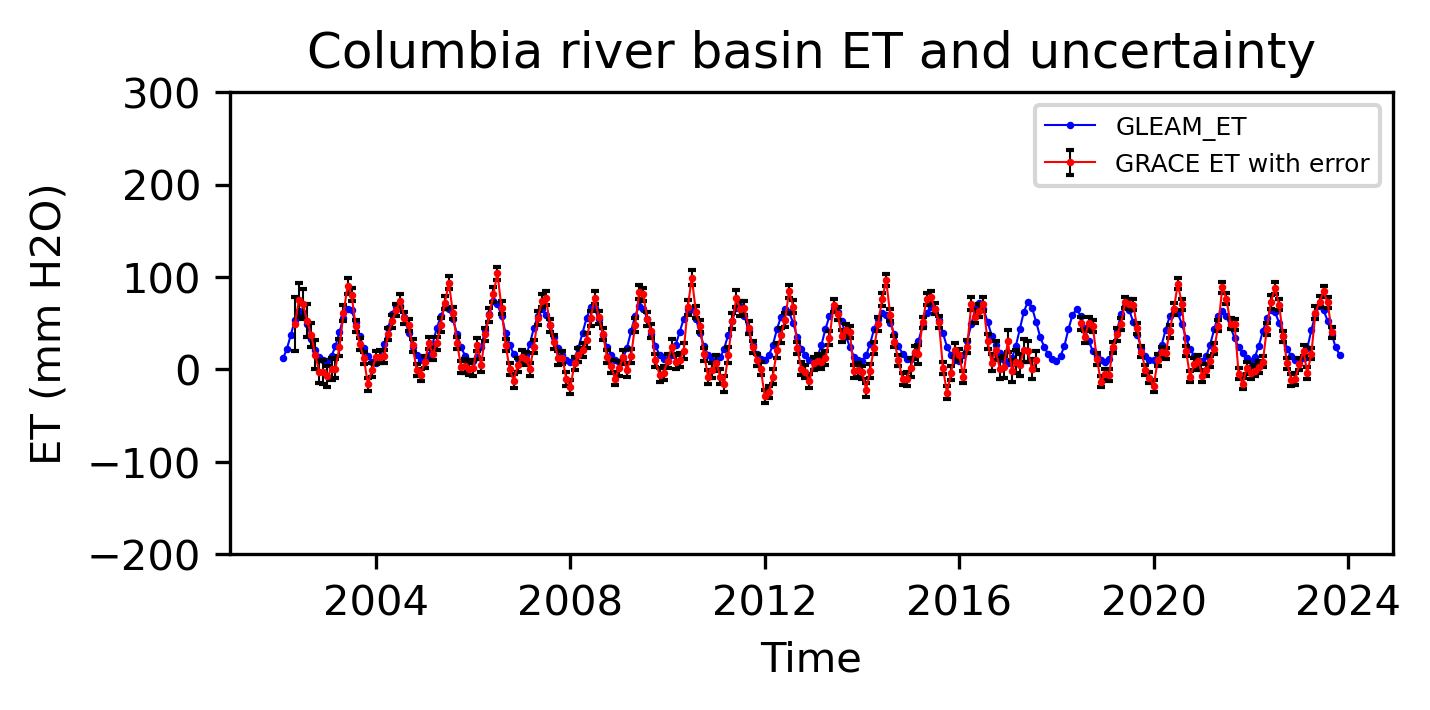

In [192]:
# read the runoff and the basin boundary
runoff1 = read_runoff("E:/01Project/04ET_assessment/01USGS_runoff/USGS_14246900.txt")
runoff_total = runoff1
allbasinmask = read_basin("E:/01Project/04ET_assessment/04Basin_Boundary/Columbia.shp")

# calculate the runoff
sum_area = np.sum(np.sum((area_weights[allbasinmask==1]))*1000000000000) #convert the unit from km^2 to mm^2
runoff_basin = convert_unit(runoff_total,sum_area)
runoff_error = 0.1*runoff_basin
# calculate the ds, pre, and ET
ds_basin,ds_error = cal_ds_error(allbasinmask)
pre_basin,pre_error = cal_pre_error(allbasinmask)
ET_basin,ET_error = cal_et_error(pre_basin,pre_error,ds_basin,ds_error,runoff_basin,runoff_error)
print(ET_basin)

GLEAM_ET = read_gleam(allbasinmask)

# plot the baisn ET and error
plt.figure(figsize=(5,2),dpi=300)
plt.ylim(-200,300)
yerr = np.array(ET_error)
plt.plot(GLEAM_ET, '-ob',linewidth=0.5,markersize =0.8,label='GLEAM_ET')
plt.legend(fontsize=6)
plt.errorbar(ET_basin.index, np.array(ET_basin), yerr=yerr,fmt='-or',linewidth=0.5,markersize =0.8, elinewidth=0.5,ecolor='k',capsize=1, label='GRACE ET with error')
plt.xlabel('Time')
plt.ylabel('ET (mm H2O)')
plt.title('Columbia river basin ET and uncertainty')
plt.legend(fontsize=6)

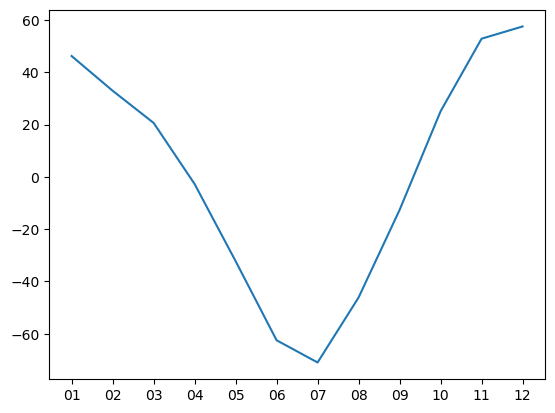

In [193]:
a,b = interannual(ds_basin)
plt.plot(b)

In [95]:
GLEAM_ET1 = pd.DataFrame({'Date':GLEAM_ET.index,'GLEAM_ET':np.array(GLEAM_ET)})
GLEAM_ET1.to_excel("E:/01Project/04ET_assessment/07GLEAM_ET_excel/Columbia_GLEAMET.xlsx", index=False)

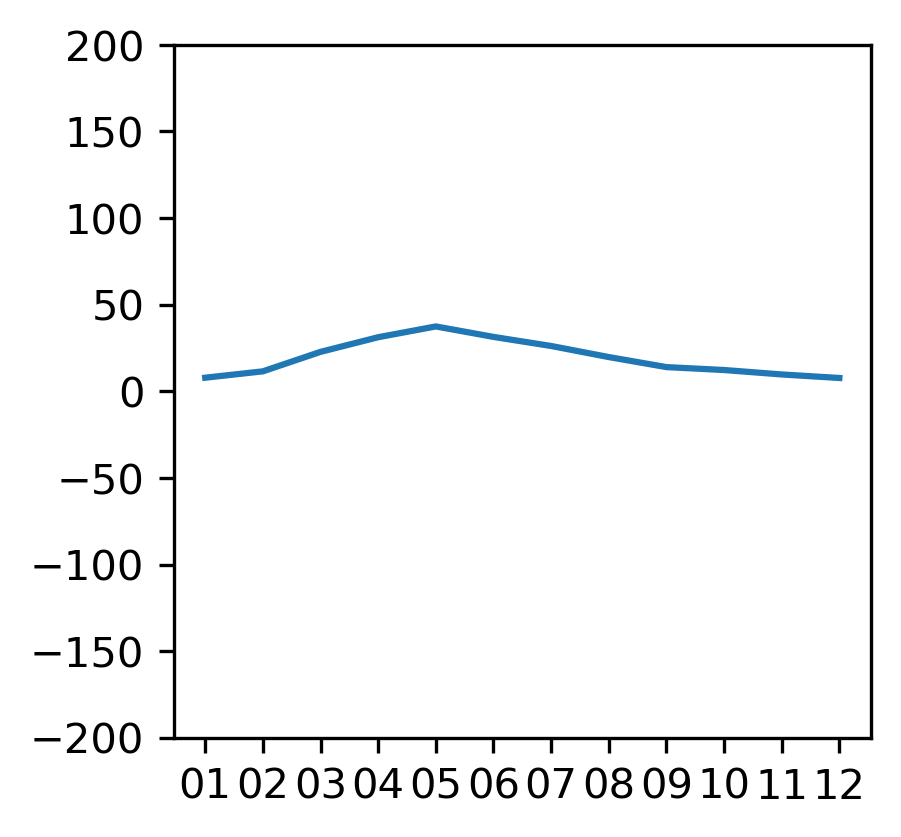

In [55]:
a,b = interannual(GLEAM_ET)
a,b = interannual(GLEAM_ET)
plt.figure(figsize=(3,3),dpi=300)
plt.ylim(-150,100)
plt.plot(b)

In [169]:
ET_uncertian1 = pd.DataFrame({'Date':ET_error.index,'ET_error':np.array(ET_error)})
ET1 = pd.DataFrame({'Date':ET_basin.index,'ET':np.array(ET_basin)})
ds1 = pd.DataFrame({'Date':ds_basin.index,'dTWS':np.array(ds_basin)})
ds_error1 = pd.DataFrame({'Date':ds_error.index,'dTWS_error':np.array(ds_error)})
pre_average1 = pd.DataFrame({'Date':pre_basin.index,'PRE':np.array(pre_basin)})
pre_error1 = pd.DataFrame({'Date':pre_error.index,'PRE_error':np.array(pre_error)})
runnoff_mm1 = pd.DataFrame({'Date':runoff_basin.index,'Runoff':np.array(runoff_basin)})
runnoff_mm2 = pd.DataFrame({'Date':runoff_error.index,'Runoff':np.array(runoff_error)})
#merge_df = pd.merge(ET1, ET_uncertian1,ds1,ds_error1,pre_average1,pre_error1,runnoff_mm1, on='Date')
merge_df = pd.merge(ET1, ET_uncertian1, on='Date')
merge_df = pd.merge(merge_df,pre_average1, on='Date')
merge_df = pd.merge(merge_df,pre_error1, on='Date')
merge_df = pd.merge(merge_df,ds1, on='Date')
merge_df = pd.merge(merge_df,ds_error1, on='Date')
merge_df = pd.merge(merge_df,runnoff_mm1, on='Date')
merge_df = pd.merge(merge_df,runnoff_mm2, on='Date')
print(merge_df)
merge_df.to_excel("E:/01Project/04ET_assessment/05GRACE-based_ET/Columbia_ET.xlsx", index=False)

          Date         ET   ET_error        PRE  PRE_error       dTWS  \
0   2002-05-01  49.380876  29.346480  43.244254   0.257263 -37.460013   
1   2002-06-01  75.400241  18.502319  41.048625   0.240221 -71.848482   
2   2002-07-01  70.729895  16.695462  15.574812   0.154060 -71.848482   
3   2002-08-01  52.665581  17.887361  17.024434   0.163044 -50.225877   
4   2002-09-01  36.926516  13.226302  27.099816   0.195976 -30.599784   
..         ...        ...        ...        ...        ...        ...   
253 2023-06-01  73.230696   6.193979  38.023218   0.625378 -68.155879   
254 2023-07-01  84.274732   6.014327  10.341114   0.308282 -71.367576   
255 2023-08-01  72.494561   6.004963  39.627924   0.637560 -56.082688   
256 2023-09-01  40.302359   5.918666  37.633886   0.606051 -12.731122   
257 2023-10-01        NaN   6.167923  39.431511   0.630747  31.113672   

     dTWS_error   Runoff_x  Runoff_y  
0     29.209506  28.203636  2.820364  
1     18.148974  35.906609  3.590661  
2     

In [394]:
print(np.mean(ds_error))

7.240952426100501


In [345]:
print((ds_error/(ds_error+pre_error+runoff_error)).head(60))
print((pre_error/(ds_error+pre_error+runoff_error)).head(60))
print((runoff_error/(ds_error+pre_error+runoff_error)).head(60))

2000-01-01         NaN
2000-02-01         NaN
2000-03-01         NaN
2000-04-01         NaN
2000-05-01         NaN
2000-06-01         NaN
2000-07-01         NaN
2000-08-01         NaN
2000-09-01         NaN
2000-10-01         NaN
2000-11-01         NaN
2000-12-01         NaN
2001-01-01         NaN
2001-02-01         NaN
2001-03-01         NaN
2001-04-01         NaN
2001-05-01         NaN
2001-06-01         NaN
2001-07-01         NaN
2001-08-01         NaN
2001-09-01         NaN
2001-10-01         NaN
2001-11-01         NaN
2001-12-01         NaN
2002-01-01         NaN
2002-02-01         NaN
2002-03-01         NaN
2002-04-01         NaN
2002-05-01    0.983773
2002-06-01    0.968011
2002-07-01    0.975351
2002-08-01    0.984742
2002-09-01    0.984507
2002-10-01    0.985722
2002-11-01    0.976189
2002-12-01    0.972097
2003-01-01    0.960365
2003-02-01    0.967063
2003-03-01    0.946101
2003-04-01    0.941703
2003-05-01    0.938022
2003-06-01    0.946274
2003-07-01    0.964397
2003-08-01 

### Read the California river basin

2002-05-01   -24.274197
2002-06-01   -54.198252
2002-07-01   -54.198252
2002-08-01   -61.510449
2002-09-01   -51.970264
                ...    
2024-05-01   -62.815656
2024-06-01   -68.353250
2024-07-01   -84.133496
2024-08-01   -54.274512
2024-09-01   -36.884925
Freq: MS, Length: 269, dtype: float64 DatetimeIndex(['2002-04-01', '2002-05-01', '2002-06-01', '2002-07-01',
               '2002-08-01', '2002-09-01', '2002-10-01', '2002-11-01',
               '2002-12-01', '2003-01-01',
               ...
               '2024-01-01', '2024-02-01', '2024-03-01', '2024-04-01',
               '2024-05-01', '2024-06-01', '2024-07-01', '2024-08-01',
               '2024-09-01', '2024-10-01'],
              dtype='datetime64[ns]', length=271, freq='MS')


Text(0.5, 1.0, 'California basin ET and uncertainty')

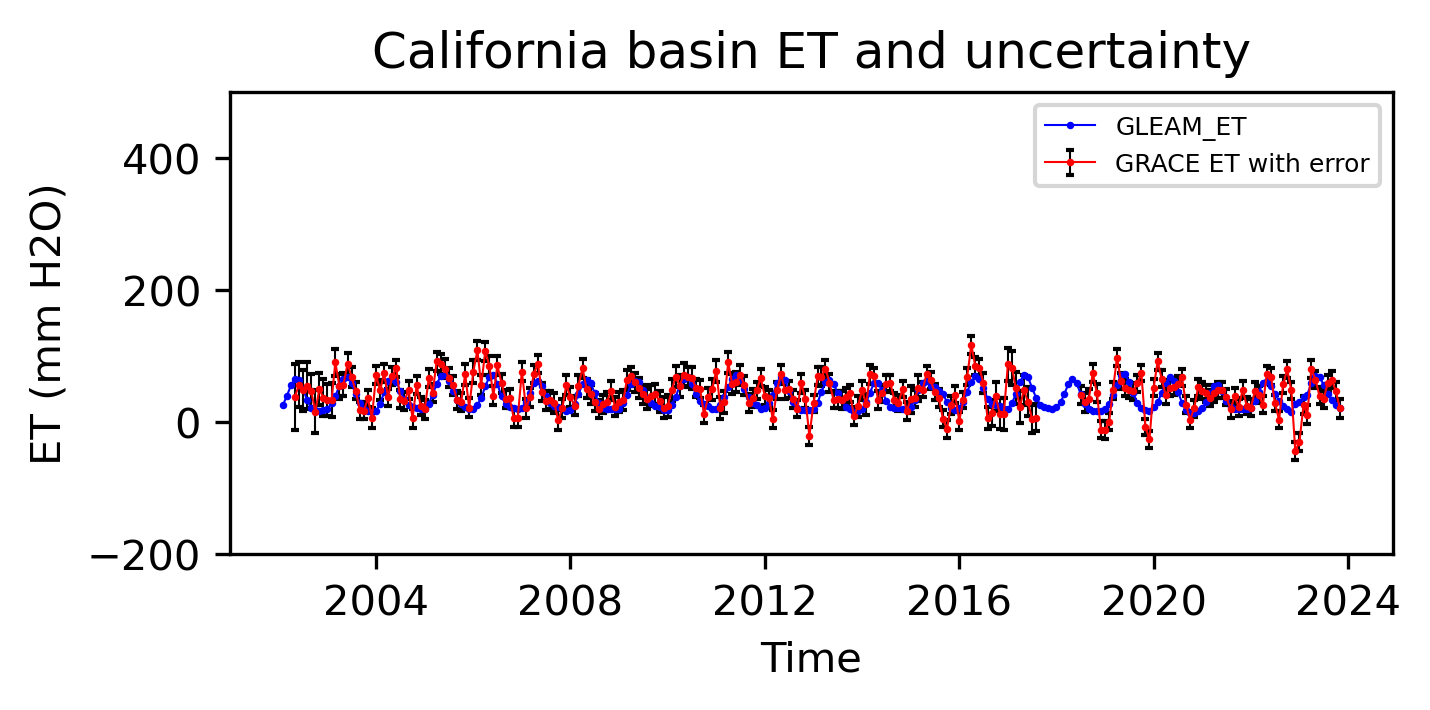

In [170]:
# read the runoff and the basin boundary
runoff_1 = read_runoff("E:/01Project/04ET_assessment/01USGS_runoff/USGS_11425500.txt")
runoff_2 = read_runoff("E:/01Project/04ET_assessment/01USGS_runoff/USGS_11303500.txt")
runoff_total = runoff_1+runoff_2
allbasinmask = read_basin("E:/01Project/04ET_assessment/04Basin_Boundary/California.shp")

# calculate the runoff
sum_area = np.sum(np.sum((area_weights[allbasinmask==1]))*1000000000000) #convert the unit from km^2 to mm^2
runoff_basin = convert_unit(runoff_total,sum_area)
runoff_error = 0.1*runoff_basin
# calculate the ds, pre, and ET
ds_basin,ds_error = cal_ds_error(allbasinmask)
pre_basin,pre_error = cal_pre_error(allbasinmask)
ET_basin,ET_error = cal_et_error(pre_basin,pre_error,ds_basin,ds_error,runoff_basin,runoff_error)

GLEAM_ET = read_gleam(allbasinmask)

# plot the baisn ET and error
plt.figure(figsize=(5,2),dpi=300)
plt.ylim(-200,500)
yerr = np.array(ET_error)
plt.errorbar(ET_basin.index, np.array(ET_basin), yerr=yerr,fmt='-or',linewidth=0.5,markersize =0.8, elinewidth=0.5,ecolor='k',capsize=1, label='GRACE ET with error')
plt.plot(GLEAM_ET, '-ob',linewidth=0.5,markersize =0.8,label='GLEAM_ET')
plt.legend(fontsize=6)
plt.xlabel('Time')
plt.ylabel('ET (mm H2O)')
plt.title('California basin ET and uncertainty')

In [98]:
GLEAM_ET1 = pd.DataFrame({'Date':GLEAM_ET.index,'GLEAM_ET':np.array(GLEAM_ET)})
GLEAM_ET1.to_excel("E:/01Project/04ET_assessment/07GLEAM_ET_excel/California_GLEAMET.xlsx", index=False)

In [171]:
ET_uncertian1 = pd.DataFrame({'Date':ET_error.index,'ET_error':np.array(ET_error)})
ET1 = pd.DataFrame({'Date':ET_basin.index,'ET':np.array(ET_basin)})
ds1 = pd.DataFrame({'Date':ds_basin.index,'dTWS':np.array(ds_basin)})
ds_error1 = pd.DataFrame({'Date':ds_error.index,'dTWS_error':np.array(ds_error)})
pre_average1 = pd.DataFrame({'Date':pre_basin.index,'PRE':np.array(pre_basin)})
pre_error1 = pd.DataFrame({'Date':pre_error.index,'PRE_error':np.array(pre_error)})
runnoff_mm1 = pd.DataFrame({'Date':runoff_basin.index,'Runoff':np.array(runoff_basin)})
runnoff_mm2 = pd.DataFrame({'Date':runoff_error.index,'Runoff':np.array(runoff_error)})
#merge_df = pd.merge(ET1, ET_uncertian1,ds1,ds_error1,pre_average1,pre_error1,runnoff_mm1, on='Date')
merge_df = pd.merge(ET1, ET_uncertian1, on='Date')
merge_df = pd.merge(merge_df,pre_average1, on='Date')
merge_df = pd.merge(merge_df,pre_error1, on='Date')
merge_df = pd.merge(merge_df,ds1, on='Date')
merge_df = pd.merge(merge_df,ds_error1, on='Date')
merge_df = pd.merge(merge_df,runnoff_mm1, on='Date')
merge_df = pd.merge(merge_df,runnoff_mm2, on='Date')
print(merge_df)
merge_df.to_excel("E:/01Project/04ET_assessment/05GRACE-based_ET/California_ET.xlsx", index=False)

          Date         ET   ET_error         PRE  PRE_error       dTWS  \
0   2002-05-01  38.135457  49.633319   25.140569   0.307193 -24.274197   
1   2002-06-01  56.924437  34.401471    3.016850   0.183554 -54.198252   
2   2002-07-01  48.227597  31.442022    1.515433   0.141718 -54.198252   
3   2002-08-01  55.034922  35.539477    0.641847   0.121967 -61.510449   
4   2002-09-01  47.061203  25.792667    1.590607   0.150603 -51.970264   
..         ...        ...        ...         ...        ...        ...   
255 2023-08-01  58.724701  12.922070   13.694486   0.848884 -55.636400   
256 2023-09-01  64.395025  12.900866   18.815599   1.032753 -54.244967   
257 2023-10-01  47.480560  13.407390   21.257073   0.966745 -24.513492   
258 2023-11-01  20.968527  13.947883   47.561570   1.540841  32.634907   
259 2023-12-01        NaN  15.250711  108.461017   2.568087  84.858934   

     dTWS_error  Runoff_x  Runoff_y  
0     49.627999  6.586261  0.658626  
1     34.395190  6.311750  0.631175

In [396]:
print(np.mean(ds_error))

15.28476509022446


### Read the Missouri river basin

2002-05-01    -4.579458
2002-06-01   -30.909696
2002-07-01   -30.909696
2002-08-01   -25.082598
2002-09-01    -9.833626
                ...    
2024-05-01     9.130913
2024-06-01   -23.816035
2024-07-01   -43.131632
2024-08-01   -36.798315
2024-09-01   -20.584920
Freq: MS, Length: 269, dtype: float64 DatetimeIndex(['2002-04-01', '2002-05-01', '2002-06-01', '2002-07-01',
               '2002-08-01', '2002-09-01', '2002-10-01', '2002-11-01',
               '2002-12-01', '2003-01-01',
               ...
               '2024-01-01', '2024-02-01', '2024-03-01', '2024-04-01',
               '2024-05-01', '2024-06-01', '2024-07-01', '2024-08-01',
               '2024-09-01', '2024-10-01'],
              dtype='datetime64[ns]', length=271, freq='MS')


Text(0.5, 1.0, 'Missouri river basin ET and uncertainty')

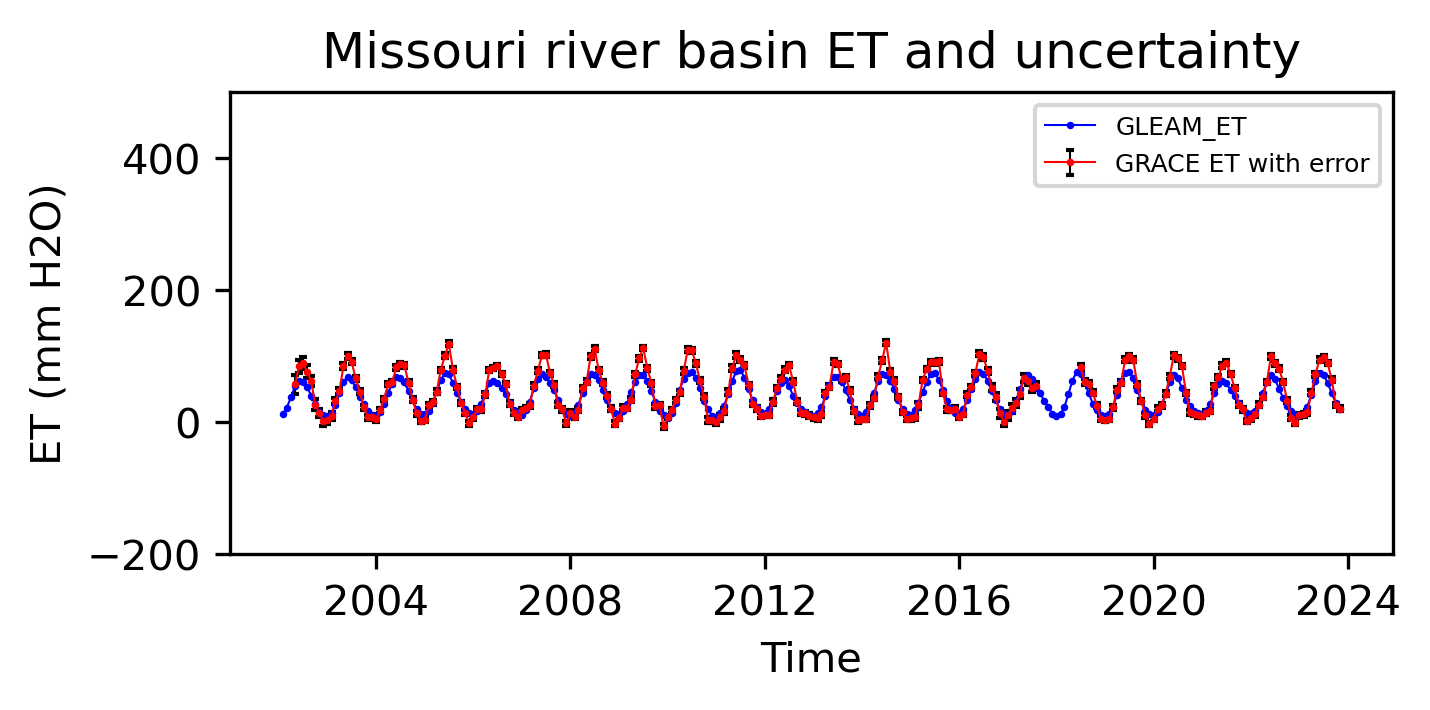

In [172]:
# read the runoff and the basin boundary
runoff_1 = read_runoff("E:/01Project/04ET_assessment/01USGS_runoff/USGS_06934500.txt")
runoff_total = runoff_1
allbasinmask = read_basin("E:/01Project/04ET_assessment/04Basin_Boundary/Missouri.shp")

# calculate the runoff
sum_area = np.sum(np.sum((area_weights[allbasinmask==1]))*1000000000000) #convert the unit from km^2 to mm^2
runoff_basin = convert_unit(runoff_total,sum_area)
runoff_error = 0.1*runoff_basin
# calculate the ds, pre, and ET
ds_basin,ds_error = cal_ds_error(allbasinmask)
pre_basin,pre_error = cal_pre_error(allbasinmask)
ET_basin,ET_error = cal_et_error(pre_basin,pre_error,ds_basin,ds_error,runoff_basin,runoff_error)

GLEAM_ET = read_gleam(allbasinmask)

# plot the baisn ET and error
plt.figure(figsize=(5,2),dpi=300)
plt.ylim(-200,500)
yerr = np.array(ET_error)
plt.errorbar(ET_basin.index, np.array(ET_basin), yerr=yerr,fmt='-or',linewidth=0.5,markersize =0.8, elinewidth=0.5,ecolor='k',capsize=1, label='GRACE ET with error')
plt.plot(GLEAM_ET, '-ob',linewidth=0.5,markersize =0.8,label='GLEAM_ET')
plt.legend(fontsize=6)
plt.xlabel('Time')
plt.ylabel('ET (mm H2O)')
plt.title('Missouri river basin ET and uncertainty')

In [101]:
GLEAM_ET1 = pd.DataFrame({'Date':GLEAM_ET.index,'GLEAM_ET':np.array(GLEAM_ET)})
GLEAM_ET1.to_excel("E:/01Project/04ET_assessment/07GLEAM_ET_excel/Missouri_GLEAMET.xlsx", index=False)

In [173]:
ET_uncertian1 = pd.DataFrame({'Date':ET_error.index,'ET_error':np.array(ET_error)})
ET1 = pd.DataFrame({'Date':ET_basin.index,'ET':np.array(ET_basin)})
ds1 = pd.DataFrame({'Date':ds_basin.index,'dTWS':np.array(ds_basin)})
ds_error1 = pd.DataFrame({'Date':ds_error.index,'dTWS_error':np.array(ds_error)})
pre_average1 = pd.DataFrame({'Date':pre_basin.index,'PRE':np.array(pre_basin)})
pre_error1 = pd.DataFrame({'Date':pre_error.index,'PRE_error':np.array(pre_error)})
runnoff_mm1 = pd.DataFrame({'Date':runoff_basin.index,'Runoff':np.array(runoff_basin)})
runnoff_mm2 = pd.DataFrame({'Date':runoff_error.index,'Runoff':np.array(runoff_error)})
#merge_df = pd.merge(ET1, ET_uncertian1,ds1,ds_error1,pre_average1,pre_error1,runnoff_mm1, on='Date')
merge_df = pd.merge(ET1, ET_uncertian1, on='Date')
merge_df = pd.merge(merge_df,pre_average1, on='Date')
merge_df = pd.merge(merge_df,pre_error1, on='Date')
merge_df = pd.merge(merge_df,ds1, on='Date')
merge_df = pd.merge(merge_df,ds_error1, on='Date')
merge_df = pd.merge(merge_df,runnoff_mm1, on='Date')
merge_df = pd.merge(merge_df,runnoff_mm2, on='Date')
print(merge_df)
merge_df.to_excel("E:/01Project/04ET_assessment/05GRACE-based_ET/Missouri_ET.xlsx", index=False)

          Date         ET   ET_error        PRE  PRE_error       dTWS  \
0   2002-05-01  57.196377  14.179163  67.979644   0.197260  -4.579458   
1   2002-06-01  84.628459  10.008918  63.654036   0.204413 -30.909696   
2   2002-07-01  89.483053   9.264847  46.809783   0.165759 -30.909696   
3   2002-08-01  76.222845   9.871520  75.205276   0.217827 -25.082598   
4   2002-09-01  61.797633   7.490068  38.352750   0.139485  -9.833626   
..         ...        ...        ...        ...        ...        ...   
255 2023-08-01  89.476612   3.529361  70.945759   0.676166 -31.052470   
256 2023-09-01  64.491679   3.485476  49.585106   0.543705  -8.297396   
257 2023-10-01  26.142987   3.633019  56.307576   0.591299  12.368346   
258 2023-11-01  20.464914   3.722563  16.503198   0.294094  11.292091   
259 2023-12-01        NaN   4.003667  28.908318   0.406107  23.208866   

     dTWS_error  Runoff_x  Runoff_y  
0     14.144780  9.669253  0.966925  
1      9.993763  5.112304  0.511230  
2      9.

In [398]:
print(np.mean(ds_error))

4.016483101638525


### Read Upper Colorado river basin

2002-05-01   -17.690128
2002-06-01   -31.860038
2002-07-01   -31.860038
2002-08-01   -18.151937
2002-09-01    -2.592271
                ...    
2024-05-01    -9.644815
2024-06-01   -37.280337
2024-07-01   -31.873046
2024-08-01   -19.502114
2024-09-01   -24.342821
Freq: MS, Length: 269, dtype: float64 DatetimeIndex(['2002-04-01', '2002-05-01', '2002-06-01', '2002-07-01',
               '2002-08-01', '2002-09-01', '2002-10-01', '2002-11-01',
               '2002-12-01', '2003-01-01',
               ...
               '2024-01-01', '2024-02-01', '2024-03-01', '2024-04-01',
               '2024-05-01', '2024-06-01', '2024-07-01', '2024-08-01',
               '2024-09-01', '2024-10-01'],
              dtype='datetime64[ns]', length=271, freq='MS')


Text(0.5, 1.0, 'Upper Colorado river basin ET and uncertainty')

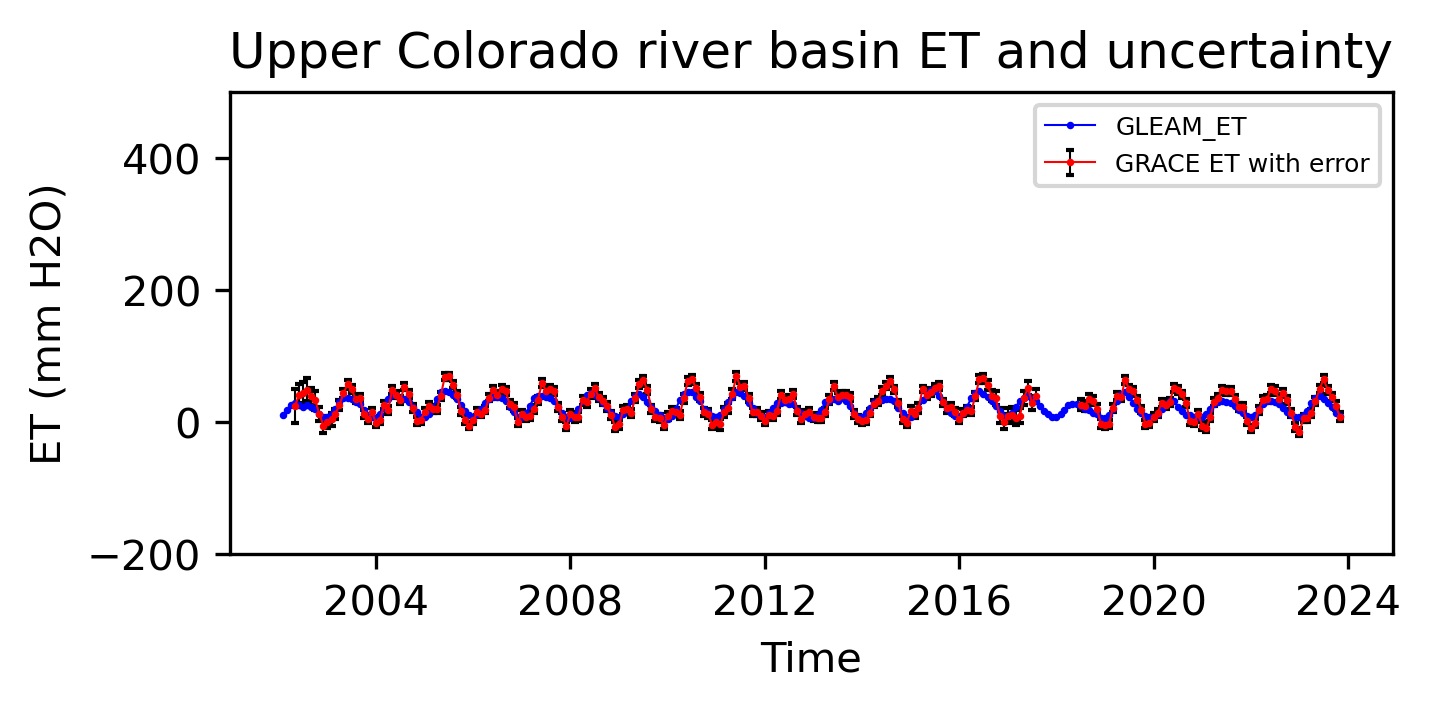

In [174]:
# read the runoff and the basin boundary
runoff_1 = read_runoff("E:/01Project/04ET_assessment/01USGS_runoff/USGS_09380000.txt")
runoff_total = runoff_1
allbasinmask = read_basin("E:/01Project/04ET_assessment/04Basin_Boundary/Upper_Colorado.shp")

# calculate the runoff
sum_area = np.sum(np.sum((area_weights[allbasinmask==1]))*1000000000000) #convert the unit from km^2 to mm^2
runoff_basin = convert_unit(runoff_total,sum_area)
runoff_error = 0.1*runoff_basin
# calculate the ds, pre, and ET
ds_basin,ds_error = cal_ds_error(allbasinmask)
pre_basin,pre_error = cal_pre_error(allbasinmask)
ET_basin,ET_error = cal_et_error(pre_basin,pre_error,ds_basin,ds_error,runoff_basin,runoff_error)

GLEAM_ET = read_gleam(allbasinmask)

# plot the baisn ET and error
plt.figure(figsize=(5,2),dpi=300)
plt.ylim(-200,500)
yerr = np.array(ET_error)
plt.errorbar(ET_basin.index, np.array(ET_basin), yerr=yerr,fmt='-or',linewidth=0.5,markersize =0.8, elinewidth=0.5,ecolor='k',capsize=1, label='GRACE ET with error')
plt.plot(GLEAM_ET, '-ob',linewidth=0.5,markersize =0.8,label='GLEAM_ET')
plt.legend(fontsize=6)

plt.xlabel('Time')
plt.ylabel('ET (mm H2O)')
plt.title('Upper Colorado river basin ET and uncertainty')

In [104]:
GLEAM_ET1 = pd.DataFrame({'Date':GLEAM_ET.index,'GLEAM_ET':np.array(GLEAM_ET)})
GLEAM_ET1.to_excel("E:/01Project/04ET_assessment/07GLEAM_ET_excel/Upper_Colorado_GLEAMET.xlsx", index=False)


In [175]:
ET_uncertian1 = pd.DataFrame({'Date':ET_error.index,'ET_error':np.array(ET_error)})
ET1 = pd.DataFrame({'Date':ET_basin.index,'ET':np.array(ET_basin)})
ds1 = pd.DataFrame({'Date':ds_basin.index,'dTWS':np.array(ds_basin)})
ds_error1 = pd.DataFrame({'Date':ds_error.index,'dTWS_error':np.array(ds_error)})
pre_average1 = pd.DataFrame({'Date':pre_basin.index,'PRE':np.array(pre_basin)})
pre_error1 = pd.DataFrame({'Date':pre_error.index,'PRE_error':np.array(pre_error)})
runnoff_mm1 = pd.DataFrame({'Date':runoff_basin.index,'Runoff':np.array(runoff_basin)})
runnoff_mm2 = pd.DataFrame({'Date':runoff_error.index,'Runoff':np.array(runoff_error)})
#merge_df = pd.merge(ET1, ET_uncertian1,ds1,ds_error1,pre_average1,pre_error1,runnoff_mm1, on='Date')
merge_df = pd.merge(ET1, ET_uncertian1, on='Date')
merge_df = pd.merge(merge_df,pre_average1, on='Date')
merge_df = pd.merge(merge_df,pre_error1, on='Date')
merge_df = pd.merge(merge_df,ds1, on='Date')
merge_df = pd.merge(merge_df,ds_error1, on='Date')
merge_df = pd.merge(merge_df,runnoff_mm1, on='Date')
merge_df = pd.merge(merge_df,runnoff_mm2, on='Date')
print(merge_df)
merge_df.to_excel("E:/01Project/04ET_assessment/05GRACE-based_ET/Upper_Colorado_ET.xlsx", index=False)

          Date         ET   ET_error        PRE  PRE_error       dTWS  \
0   2002-05-01  24.677188  25.191192   7.962999   0.173182 -17.690128   
1   2002-06-01  40.588266  17.380483   4.522017   0.137497 -31.860038   
2   2002-07-01  44.352062  16.005733  21.928575   0.246692 -31.860038   
3   2002-08-01  49.450316  16.842082  20.346492   0.222034 -18.151937   
4   2002-09-01  39.002555  12.746661  59.969956   0.407030  -2.592271   
..         ...        ...        ...        ...        ...        ...   
255 2023-08-01  49.369992   6.170413  47.084970   1.174419 -24.186246   
256 2023-09-01  38.433013   6.084002  22.241963   0.788991 -10.119032   
257 2023-10-01  25.088032   6.338024  22.326775   0.766522  -4.105252   
258 2023-11-01   8.200065   6.560308  23.655474   0.788777  11.778341   
259 2023-12-01        NaN   7.054647  19.718985   0.757278  16.811319   

     dTWS_error  Runoff_x  Runoff_y  
0     25.189654  2.179778  0.217978  
1     17.377773  2.744017  0.274402  
2     16.

In [400]:
print(np.mean(ds_error))

6.813098244873882


### Read Colorado river basin

2002-05-01    -3.237954
2002-06-01    -7.540606
2002-07-01    -7.540606
2002-08-01    -6.096542
2002-09-01    -5.495503
                ...    
2024-05-01   -13.212586
2024-06-01   -14.113952
2024-07-01   -10.918057
2024-08-01    -5.771066
2024-09-01   -13.421693
Freq: MS, Length: 269, dtype: float64 DatetimeIndex(['2002-04-01', '2002-05-01', '2002-06-01', '2002-07-01',
               '2002-08-01', '2002-09-01', '2002-10-01', '2002-11-01',
               '2002-12-01', '2003-01-01',
               ...
               '2024-01-01', '2024-02-01', '2024-03-01', '2024-04-01',
               '2024-05-01', '2024-06-01', '2024-07-01', '2024-08-01',
               '2024-09-01', '2024-10-01'],
              dtype='datetime64[ns]', length=271, freq='MS')


Text(0.5, 1.0, 'Lower Colorado river basin ET and uncertainty')

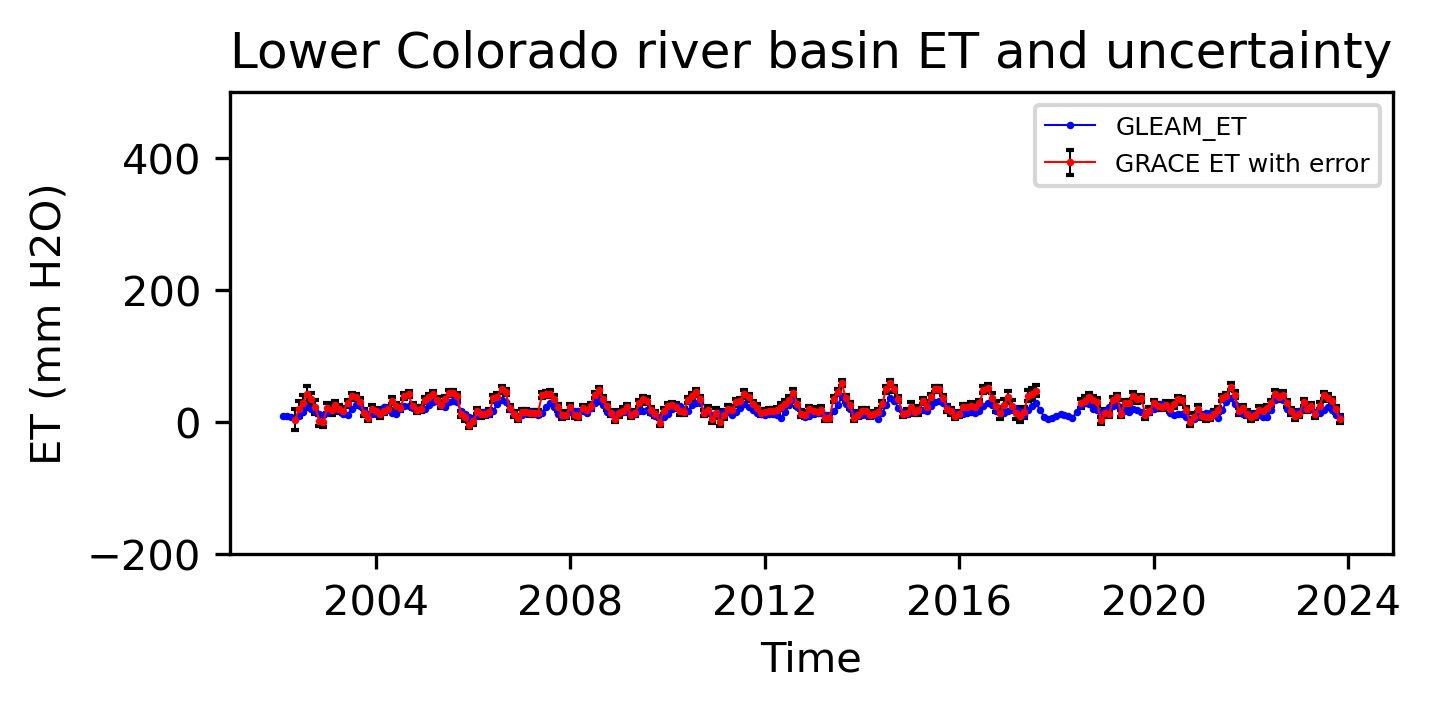

In [176]:
# read the runoff and the basin boundary
runoff_1 = read_runoff("E:/01Project/04ET_assessment/01USGS_runoff/USGS_09429490.txt")
runoff_total = runoff_1
allbasinmask = read_basin("E:/01Project/04ET_assessment/04Basin_Boundary/Lower_Colorado.shp")

# calculate the runoff
sum_area = np.sum(np.sum((area_weights[allbasinmask==1]))*1000000000000) #convert the unit from km^2 to mm^2
runoff_basin = convert_unit(runoff_total,sum_area)
runoff_error = 0.1*runoff_basin
# calculate the ds, pre, and ET
ds_basin,ds_error = cal_ds_error(allbasinmask)
pre_basin,pre_error = cal_pre_error(allbasinmask)
ET_basin,ET_error = cal_et_error(pre_basin,pre_error,ds_basin,ds_error,runoff_basin,runoff_error)

GLEAM_ET = read_gleam(allbasinmask)

# plot the baisn ET and error
plt.figure(figsize=(5,2),dpi=300)
plt.ylim(-200,500)
yerr = np.array(ET_error)
plt.errorbar(ET_basin.index, np.array(ET_basin), yerr=yerr,fmt='-or',linewidth=0.5,markersize =0.8, elinewidth=0.5,ecolor='k',capsize=1, label='GRACE ET with error')
plt.plot(GLEAM_ET, '-ob',linewidth=0.5,markersize =0.8,label='GLEAM_ET')
plt.legend(fontsize=6)

plt.xlabel('Time')
plt.ylabel('ET (mm H2O)')
plt.title('Lower Colorado river basin ET and uncertainty')

In [107]:
GLEAM_ET1 = pd.DataFrame({'Date':GLEAM_ET.index,'GLEAM_ET':np.array(GLEAM_ET)})
GLEAM_ET1.to_excel("E:/01Project/04ET_assessment/07GLEAM_ET_excel/Lower_Colorado_GLEAMET.xlsx", index=False)

In [177]:
ET_uncertian1 = pd.DataFrame({'Date':ET_error.index,'ET_error':np.array(ET_error)})
ET1 = pd.DataFrame({'Date':ET_basin.index,'ET':np.array(ET_basin)})
ds1 = pd.DataFrame({'Date':ds_basin.index,'dTWS':np.array(ds_basin)})
ds_error1 = pd.DataFrame({'Date':ds_error.index,'dTWS_error':np.array(ds_error)})
pre_average1 = pd.DataFrame({'Date':pre_basin.index,'PRE':np.array(pre_basin)})
pre_error1 = pd.DataFrame({'Date':pre_error.index,'PRE_error':np.array(pre_error)})
runnoff_mm1 = pd.DataFrame({'Date':runoff_basin.index,'Runoff':np.array(runoff_basin)})
runnoff_mm2 = pd.DataFrame({'Date':runoff_error.index,'Runoff':np.array(runoff_error)})
#merge_df = pd.merge(ET1, ET_uncertian1,ds1,ds_error1,pre_average1,pre_error1,runnoff_mm1, on='Date')
merge_df = pd.merge(ET1, ET_uncertian1, on='Date')
merge_df = pd.merge(merge_df,pre_average1, on='Date')
merge_df = pd.merge(merge_df,pre_error1, on='Date')
merge_df = pd.merge(merge_df,ds1, on='Date')
merge_df = pd.merge(merge_df,ds_error1, on='Date')
merge_df = pd.merge(merge_df,runnoff_mm1, on='Date')
merge_df = pd.merge(merge_df,runnoff_mm2, on='Date')
print(merge_df)
merge_df.to_excel("E:/01Project/04ET_assessment/05GRACE-based_ET/Lower_Colorado_ET.xlsx", index=False)

          Date         ET   ET_error        PRE  PRE_error       dTWS  \
0   2002-05-01   3.703213  15.875639   0.797312   0.092037  -3.237954   
1   2002-06-01  19.348155  12.139969   0.968849   0.085296  -7.540606   
2   2002-07-01  29.239971  11.363293  38.375739   0.308200  -7.540606   
3   2002-08-01  42.875750  12.343655  30.308178   0.259744  -6.096542   
4   2002-09-01  35.447986   9.487333  45.971501   0.332787  -5.495503   
..         ...        ...        ...        ...        ...        ...   
255 2023-08-01  36.773544   5.284822  50.284007   1.037513  -6.715897   
256 2023-09-01  31.361243   5.221007  22.226782   0.653779  -5.028425   
257 2023-10-01  19.231125   5.404542   9.464622   0.454401  -5.863584   
258 2023-11-01   4.665879   5.611946  11.197432   0.482167   8.061472   
259 2023-12-01        NaN   6.042270  19.933266   0.624504  14.331793   

     dTWS_error  Runoff_x  Runoff_y  
0     15.874571  1.594354  0.159435  
1     12.138751  1.493103  0.149310  
2     11.

In [402]:
print(np.mean(ds_error))

5.6239071244469105


### Read Arkansas-White-Red basin

2002-05-01   -17.102331
2002-06-01   -42.766890
2002-07-01   -42.766890
2002-08-01   -35.676100
2002-09-01    -3.604923
                ...    
2024-05-01    -2.002756
2024-06-01   -39.594672
2024-07-01   -60.704409
2024-08-01   -41.999857
2024-09-01   -15.439673
Freq: MS, Length: 269, dtype: float64 DatetimeIndex(['2002-04-01', '2002-05-01', '2002-06-01', '2002-07-01',
               '2002-08-01', '2002-09-01', '2002-10-01', '2002-11-01',
               '2002-12-01', '2003-01-01',
               ...
               '2024-01-01', '2024-02-01', '2024-03-01', '2024-04-01',
               '2024-05-01', '2024-06-01', '2024-07-01', '2024-08-01',
               '2024-09-01', '2024-10-01'],
              dtype='datetime64[ns]', length=271, freq='MS')


Text(0.5, 1.0, 'Arkansas-White-Red region ET and uncertainty')

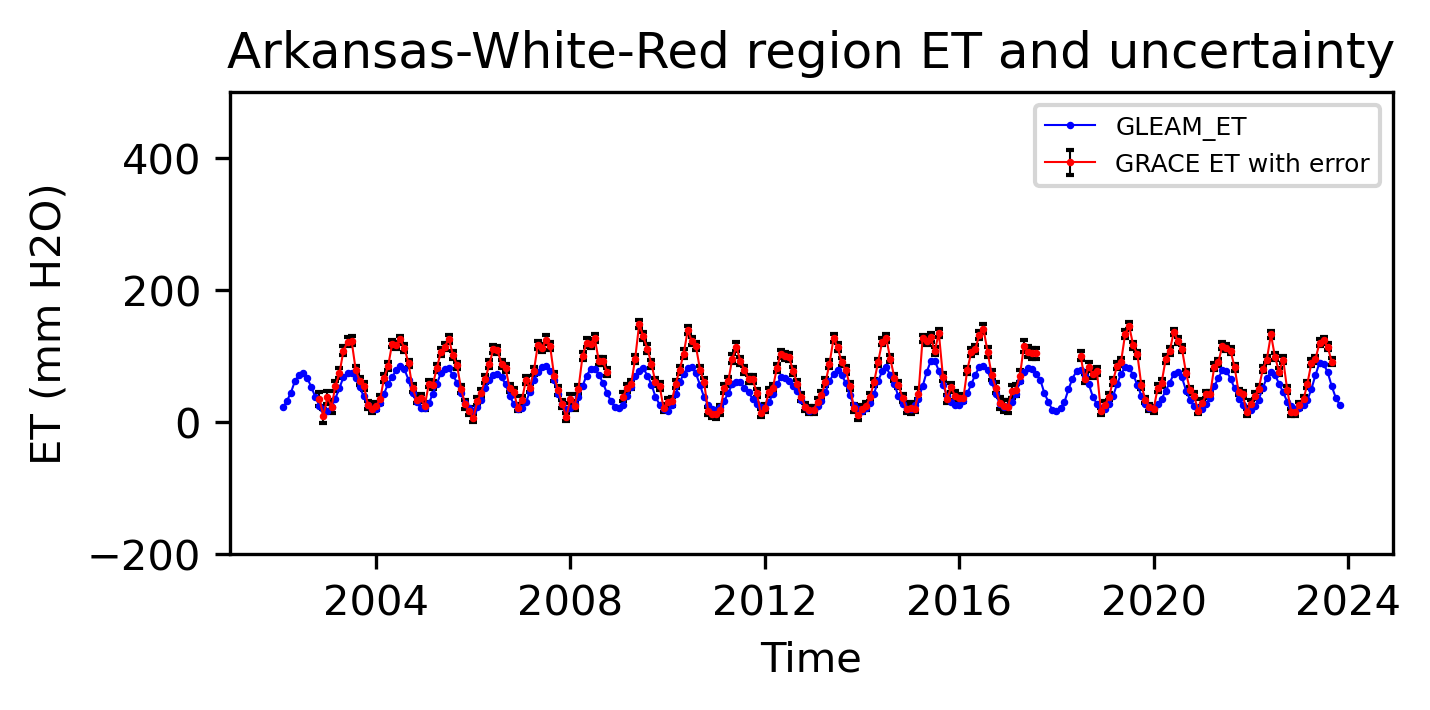

In [178]:
# read the runoff and the basin boundary
runoff_1 = read_runoff("E:/01Project/04ET_assessment/01USGS_runoff/USGS_07344370.txt")
runoff_2 = read_runoff("E:/01Project/04ET_assessment/01USGS_runoff/USGS_07249455.txt")
runoff_total = runoff_1+runoff_2
allbasinmask = read_basin("E:/01Project/04ET_assessment/04Basin_Boundary/Arkansas_White_Red_region.shp")

# calculate the runoff
sum_area = np.sum(np.sum((area_weights[allbasinmask==1]))*1000000000000) #convert the unit from km^2 to mm^2
runoff_basin = convert_unit(runoff_total,sum_area)
runoff_error = 0.1*runoff_basin
# calculate the ds, pre, and ET
ds_basin,ds_error = cal_ds_error(allbasinmask)
pre_basin,pre_error = cal_pre_error(allbasinmask)
ET_basin,ET_error = cal_et_error(pre_basin,pre_error,ds_basin,ds_error,runoff_basin,runoff_error)

GLEAM_ET = read_gleam(allbasinmask)

# plot the baisn ET and error
plt.figure(figsize=(5,2),dpi=300)
plt.ylim(-200,500)
yerr = np.array(ET_error)
plt.errorbar(ET_basin.index, np.array(ET_basin), yerr=yerr,fmt='-or',linewidth=0.5,markersize =0.8, elinewidth=0.5,ecolor='k',capsize=1, label='GRACE ET with error')
plt.plot(GLEAM_ET, '-ob',linewidth=0.5,markersize =0.8,label='GLEAM_ET')
plt.legend(fontsize=6)

plt.xlabel('Time')
plt.ylabel('ET (mm H2O)')
plt.title('Arkansas-White-Red region ET and uncertainty')

In [110]:
GLEAM_ET1 = pd.DataFrame({'Date':GLEAM_ET.index,'GLEAM_ET':np.array(GLEAM_ET)})
GLEAM_ET1.to_excel("E:/01Project/04ET_assessment/07GLEAM_ET_excel/Arkansas_White_Red_GLEAMET.xlsx", index=False)


In [179]:
ET_uncertian1 = pd.DataFrame({'Date':ET_error.index,'ET_error':np.array(ET_error)})
ET1 = pd.DataFrame({'Date':ET_basin.index,'ET':np.array(ET_basin)})
ds1 = pd.DataFrame({'Date':ds_basin.index,'dTWS':np.array(ds_basin)})
ds_error1 = pd.DataFrame({'Date':ds_error.index,'dTWS_error':np.array(ds_error)})
pre_average1 = pd.DataFrame({'Date':pre_basin.index,'PRE':np.array(pre_basin)})
pre_error1 = pd.DataFrame({'Date':pre_error.index,'PRE_error':np.array(pre_error)})
runnoff_mm1 = pd.DataFrame({'Date':runoff_basin.index,'Runoff':np.array(runoff_basin)})
runnoff_mm2 = pd.DataFrame({'Date':runoff_error.index,'Runoff':np.array(runoff_error)})
#merge_df = pd.merge(ET1, ET_uncertian1,ds1,ds_error1,pre_average1,pre_error1,runnoff_mm1, on='Date')
merge_df = pd.merge(ET1, ET_uncertian1, on='Date')
merge_df = pd.merge(merge_df,pre_average1, on='Date')
merge_df = pd.merge(merge_df,pre_error1, on='Date')
merge_df = pd.merge(merge_df,ds1, on='Date')
merge_df = pd.merge(merge_df,ds_error1, on='Date')
merge_df = pd.merge(merge_df,runnoff_mm1, on='Date')
merge_df = pd.merge(merge_df,runnoff_mm2, on='Date')
print(merge_df)
merge_df.to_excel("E:/01Project/04ET_assessment/05GRACE-based_ET/Arkansas_White_Red_ET.xlsx", index=False)

          Date          ET  ET_error        PRE  PRE_error       dTWS  \
0   2002-05-01         NaN       NaN  97.834583   0.331377 -17.102331   
1   2002-06-01         NaN       NaN  78.008490   0.273105 -42.766890   
2   2002-07-01         NaN       NaN  83.563089   0.298588 -42.766890   
3   2002-08-01         NaN       NaN  75.271037   0.282842 -35.676100   
4   2002-09-01         NaN       NaN  60.822936   0.251354  -3.604923   
..         ...         ...       ...        ...        ...        ...   
255 2023-08-01  114.241623  5.252937  61.954750   0.921982 -39.548846   
256 2023-09-01   91.682934  5.242075  64.335931   0.906902 -23.171957   
257 2023-10-01         NaN  5.491295  84.264403   1.102204  10.953989   
258 2023-11-01         NaN       NaN  35.101301   0.670090  27.025270   
259 2023-12-01         NaN       NaN  60.873279   0.879047  43.849023   

     dTWS_error  Runoff_x  Runoff_y  
0     25.156360       NaN       NaN  
1     16.975633       NaN       NaN  
2     15.

In [404]:
print(np.mean(ds_error))

6.460640721874521


### Read Texas-Gulf region

2002-05-01   -21.423626
2002-06-01   -22.942525
2002-07-01   -22.942525
2002-08-01    -4.464108
2002-09-01    17.049981
                ...    
2024-05-01     5.037361
2024-06-01   -29.817878
2024-07-01   -51.548416
2024-08-01   -21.860187
2024-09-01    -3.333774
Freq: MS, Length: 269, dtype: float64 DatetimeIndex(['2002-04-01', '2002-05-01', '2002-06-01', '2002-07-01',
               '2002-08-01', '2002-09-01', '2002-10-01', '2002-11-01',
               '2002-12-01', '2003-01-01',
               ...
               '2024-01-01', '2024-02-01', '2024-03-01', '2024-04-01',
               '2024-05-01', '2024-06-01', '2024-07-01', '2024-08-01',
               '2024-09-01', '2024-10-01'],
              dtype='datetime64[ns]', length=271, freq='MS')
2000-01-01   NaN
2000-02-01   NaN
2000-03-01   NaN
2000-04-01   NaN
2000-05-01   NaN
              ..
2024-05-01   NaN
2024-06-01   NaN
2024-07-01   NaN
2024-08-01   NaN
2024-09-01   NaN
Length: 297, dtype: float64


Text(0.5, 1.0, 'Texas-Gulf region ET and uncertainty')

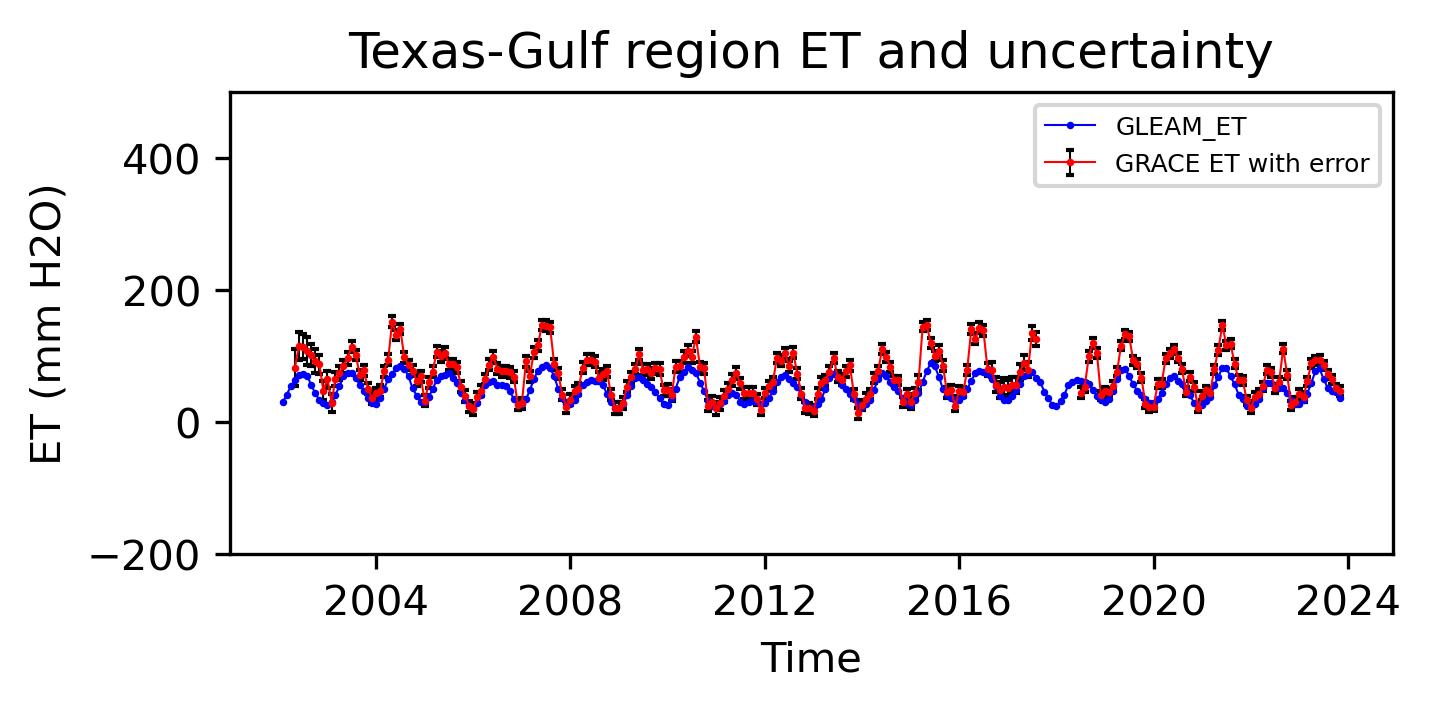

In [182]:
# read the runoff and the basin boundary
runoff_1 = read_runoff("E:/01Project/04ET_assessment/01USGS_runoff/USGS_08116650.txt")
runoff_2 = read_runoff("E:/01Project/04ET_assessment/01USGS_runoff/USGS_08030500.txt")
runoff_3 = read_runoff("E:/01Project/04ET_assessment/01USGS_runoff/USGS_08067070.txt")
runoff_total = runoff_1+runoff_2+runoff_3
runoff_error = 0.1*runoff_basin
allbasinmask = read_basin("E:/01Project/04ET_assessment/04Basin_Boundary/Texas_Gulf_region.shp")

# calculate the runoff
sum_area = np.sum(np.sum((area_weights[allbasinmask==1]))*1000000000000) #convert the unit from km^2 to mm^2
runoff_basin = convert_unit(runoff_total,sum_area)
# calculate the ds, pre, and ET
ds_basin,ds_error = cal_ds_error(allbasinmask)
pre_basin,pre_error = cal_pre_error(allbasinmask)
ET_basin,ET_error = cal_et_error(pre_basin,pre_error,ds_basin,ds_error,runoff_basin,runoff_error)
print(ET_error)

GLEAM_ET = read_gleam(allbasinmask)

# plot the baisn ET and error
plt.figure(figsize=(5,2),dpi=300)
plt.ylim(-200,500)
yerr = np.array(ET_error)
plt.errorbar(ET_basin.index, np.array(ET_basin), yerr=yerr,fmt='-or',linewidth=0.5,markersize =0.8, elinewidth=0.5,ecolor='k',capsize=1, label='GRACE ET with error')
plt.plot(GLEAM_ET, '-ob',linewidth=0.5,markersize =0.8,label='GLEAM_ET')
plt.legend(fontsize=6)
plt.xlabel('Time')
plt.ylabel('ET (mm H2O)')
plt.title('Texas-Gulf region ET and uncertainty')

In [113]:
GLEAM_ET1 = pd.DataFrame({'Date':GLEAM_ET.index,'GLEAM_ET':np.array(GLEAM_ET)})
GLEAM_ET1.to_excel("E:/01Project/04ET_assessment/07GLEAM_ET_excel/Texas_Gulf_GLEAMET.xlsx", index=False)

In [183]:
ET_uncertian1 = pd.DataFrame({'Date':ET_error.index,'ET_error':np.array(ET_error)})
ET1 = pd.DataFrame({'Date':ET_basin.index,'ET':np.array(ET_basin)})
ds1 = pd.DataFrame({'Date':ds_basin.index,'dTWS':np.array(ds_basin)})
ds_error1 = pd.DataFrame({'Date':ds_error.index,'dTWS_error':np.array(ds_error)})
pre_average1 = pd.DataFrame({'Date':pre_basin.index,'PRE':np.array(pre_basin)})
pre_error1 = pd.DataFrame({'Date':pre_error.index,'PRE_error':np.array(pre_error)})
runnoff_mm1 = pd.DataFrame({'Date':runoff_basin.index,'Runoff':np.array(runoff_basin)})
runnoff_mm2 = pd.DataFrame({'Date':runoff_error.index,'Runoff':np.array(runoff_error)})
#merge_df = pd.merge(ET1, ET_uncertian1,ds1,ds_error1,pre_average1,pre_error1,runnoff_mm1, on='Date')
merge_df = pd.merge(ET1, ET_uncertian1, on='Date')
merge_df = pd.merge(merge_df,pre_average1, on='Date')
merge_df = pd.merge(merge_df,pre_error1, on='Date')
merge_df = pd.merge(merge_df,ds1, on='Date')
merge_df = pd.merge(merge_df,ds_error1, on='Date')
merge_df = pd.merge(merge_df,runnoff_mm1, on='Date')
merge_df = pd.merge(merge_df,runnoff_mm2, on='Date')
print(merge_df)
merge_df.to_excel("E:/01Project/04ET_assessment/05GRACE-based_ET/Texas_Gulf_ET.xlsx", index=False)

          Date          ET   ET_error         PRE  PRE_error       dTWS  \
0   2002-05-01   82.774411  28.132510   59.888292   0.300930 -21.423626   
1   2002-06-01  115.993931  21.059021   73.703578   0.335851 -22.942525   
2   2002-07-01  114.593945  19.530702  148.680878   0.532687 -22.942525   
3   2002-08-01  107.301779  21.239679   56.633055   0.321751  -4.464108   
4   2002-09-01  101.771459  16.168253  107.696687   0.523032  17.049981   
..         ...         ...        ...         ...        ...        ...   
255 2023-08-01   72.612913   6.815978   19.615536   0.585299 -35.271950   
256 2023-09-01   65.097929   6.850782   64.104204   1.011103   1.530341   
257 2023-10-01   51.062677   7.225686  117.392943   1.459125  26.643943   
258 2023-11-01   47.765625   7.400573   52.838168   0.945449  24.232125   
259 2023-12-01         NaN   7.972488   46.972361   0.820874  34.544677   

     dTWS_error  Runoff_x  Runoff_y  
0     28.130774  0.840941  0.084094  
1     21.056229  0.6912

In [406]:
print(np.mean(ds_error))

8.659660472068818


### Read Rio-Grande region

2002-05-01    0.853470
2002-06-01   -1.057185
2002-07-01   -1.057185
2002-08-01   -2.363720
2002-09-01   -1.669121
                ...   
2024-05-01   -2.463063
2024-06-01    3.371599
2024-07-01   -4.040457
2024-08-01   -6.778041
2024-09-01   -7.912854
Freq: MS, Length: 269, dtype: float64 DatetimeIndex(['2002-04-01', '2002-05-01', '2002-06-01', '2002-07-01',
               '2002-08-01', '2002-09-01', '2002-10-01', '2002-11-01',
               '2002-12-01', '2003-01-01',
               ...
               '2024-01-01', '2024-02-01', '2024-03-01', '2024-04-01',
               '2024-05-01', '2024-06-01', '2024-07-01', '2024-08-01',
               '2024-09-01', '2024-10-01'],
              dtype='datetime64[ns]', length=271, freq='MS')


Text(0.5, 1.0, 'Rio-Grande region ET and uncertainty')

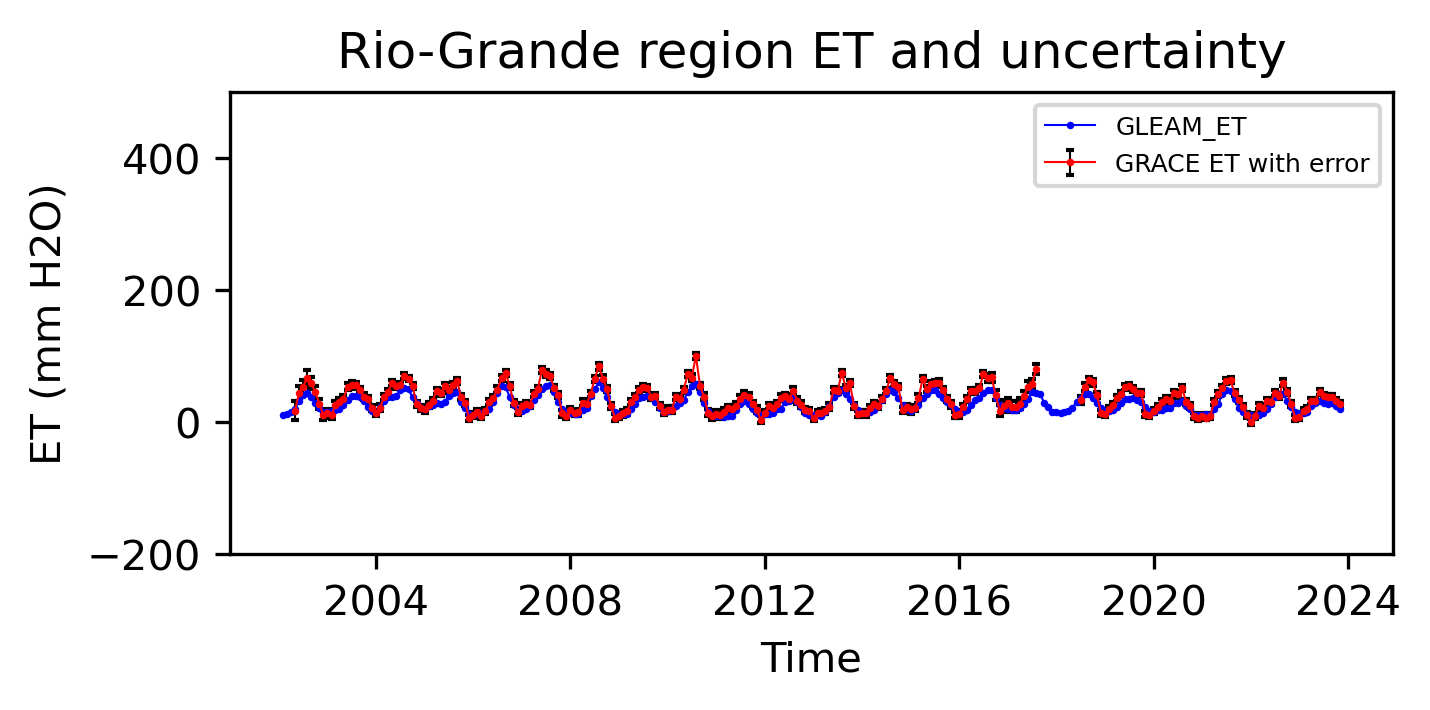

In [184]:
# read the runoff and the basin boundary
import pandas as pd
df = pd.read_csv("E:/01Project/04ET_assessment/01USGS_runoff/BulkExport-08475000-20250107170359/08475000.csv",skiprows = 1)
df = df.iloc[:-1]
df['End of Interval (UTC-06:00)'] = pd.to_datetime(df['End of Interval (UTC-06:00)']).apply(lambda x: x.replace(day=1))
total_runoff = pd.Series([value for value in df['Value (ft^3/s)']],df['End of Interval (UTC-06:00)'])
allbasinmask = read_basin("E:/01Project/04ET_assessment/04Basin_Boundary/Rio_Grande_region.shp")

# calculate the runoff
sum_area = np.sum(np.sum((area_weights[allbasinmask==1]))*1000000000000) #convert the unit from km^2 to mm^2
runoff_basin = convert_unit(runoff_total,sum_area)
runoff_error = 0.1*runoff_basin
# calculate the ds, pre, and ET
ds_basin,ds_error = cal_ds_error(allbasinmask)
pre_basin,pre_error = cal_pre_error(allbasinmask)
ET_basin,ET_error = cal_et_error(pre_basin,pre_error,ds_basin,ds_error,runoff_basin,runoff_error)

GLEAM_ET = read_gleam(allbasinmask)

# plot the baisn ET and error
plt.figure(figsize=(5,2),dpi=300)
plt.ylim(-200,500)
yerr = np.array(ET_error)
plt.errorbar(ET_basin.index, np.array(ET_basin), yerr=yerr,fmt='-or',linewidth=0.5,markersize =0.8, elinewidth=0.5,ecolor='k',capsize=1, label='GRACE ET with error')
plt.plot(GLEAM_ET, '-ob',linewidth=0.5,markersize =0.8,label='GLEAM_ET')
plt.legend(fontsize=6)
plt.xlabel('Time')
plt.ylabel('ET (mm H2O)')
plt.title('Rio-Grande region ET and uncertainty')

In [116]:
GLEAM_ET1 = pd.DataFrame({'Date':GLEAM_ET.index,'GLEAM_ET':np.array(GLEAM_ET)})
GLEAM_ET1.to_excel("E:/01Project/04ET_assessment/07GLEAM_ET_excel/Rio-Grande_GLEAMET.xlsx", index=False)


In [185]:
ET_uncertian1 = pd.DataFrame({'Date':ET_error.index,'ET_error':np.array(ET_error)})
ET1 = pd.DataFrame({'Date':ET_basin.index,'ET':np.array(ET_basin)})
ds1 = pd.DataFrame({'Date':ds_basin.index,'dTWS':np.array(ds_basin)})
ds_error1 = pd.DataFrame({'Date':ds_error.index,'dTWS_error':np.array(ds_error)})
pre_average1 = pd.DataFrame({'Date':pre_basin.index,'PRE':np.array(pre_basin)})
pre_error1 = pd.DataFrame({'Date':pre_error.index,'PRE_error':np.array(pre_error)})
runnoff_mm1 = pd.DataFrame({'Date':runoff_basin.index,'Runoff':np.array(runoff_basin)})
runnoff_mm2 = pd.DataFrame({'Date':runoff_error.index,'Runoff':np.array(runoff_error)})
#merge_df = pd.merge(ET1, ET_uncertian1,ds1,ds_error1,pre_average1,pre_error1,runnoff_mm1, on='Date')
merge_df = pd.merge(ET1, ET_uncertian1, on='Date')
merge_df = pd.merge(merge_df,pre_average1, on='Date')
merge_df = pd.merge(merge_df,pre_error1, on='Date')
merge_df = pd.merge(merge_df,ds1, on='Date')
merge_df = pd.merge(merge_df,ds_error1, on='Date')
merge_df = pd.merge(merge_df,runnoff_mm1, on='Date')
merge_df = pd.merge(merge_df,runnoff_mm2, on='Date')
print(merge_df)
merge_df.to_excel("E:/01Project/04ET_assessment/05GRACE-based_ET/Rio_Grande_ET.xlsx", index=False)

          Date         ET   ET_error        PRE  PRE_error      dTWS  \
0   2002-05-01  17.422262  13.906919  15.172419   0.234550  0.853470   
1   2002-06-01  43.722297  10.922085  27.897505   0.307559 -1.057185   
2   2002-07-01  53.202836  10.250274  84.925745   0.639069 -1.057185   
3   2002-08-01  67.499180  11.228926  43.614136   0.395486 -2.363720   
4   2002-09-01  59.267095   8.638659  66.866976   0.441628 -1.669121   
..         ...        ...        ...        ...        ...       ...   
255 2023-08-01  38.227423   4.639150  37.074239   0.789056 -7.872987   
256 2023-09-01  38.153325   4.604926  31.379516   0.674480 -1.273315   
257 2023-10-01  31.875023   4.833065  42.186406   0.862568  1.815354   
258 2023-11-01  26.777977   4.962953  27.505337   0.686608  3.386382   
259 2023-12-01        NaN   5.312712  20.801463   0.562219  5.566927   

     dTWS_error  Runoff_x  Runoff_y  
0     13.904941  0.000090  0.000009  
1     10.917753  0.000072  0.000007  
2     10.230332  0.00

In [414]:
print(np.mean(ET_error),np.mean(ds_error),np.mean(pre_error),np.mean(runoff_error))

5.1202072973058055 5.202217310401857 0.511611000277743 2.6120725380182694e-09


### Read Endorheic basin

2002-05-01   -16.855133
2002-06-01   -32.169975
2002-07-01   -32.169975
2002-08-01   -26.721388
2002-09-01   -14.447241
                ...    
2024-05-01   -34.653663
2024-06-01   -47.147996
2024-07-01   -39.737701
2024-08-01   -14.877021
2024-09-01   -16.906961
Freq: MS, Length: 269, dtype: float64 DatetimeIndex(['2002-04-01', '2002-05-01', '2002-06-01', '2002-07-01',
               '2002-08-01', '2002-09-01', '2002-10-01', '2002-11-01',
               '2002-12-01', '2003-01-01',
               ...
               '2024-01-01', '2024-02-01', '2024-03-01', '2024-04-01',
               '2024-05-01', '2024-06-01', '2024-07-01', '2024-08-01',
               '2024-09-01', '2024-10-01'],
              dtype='datetime64[ns]', length=271, freq='MS')


Text(0.5, 1.0, 'Endorheic basin ET and uncertainty')

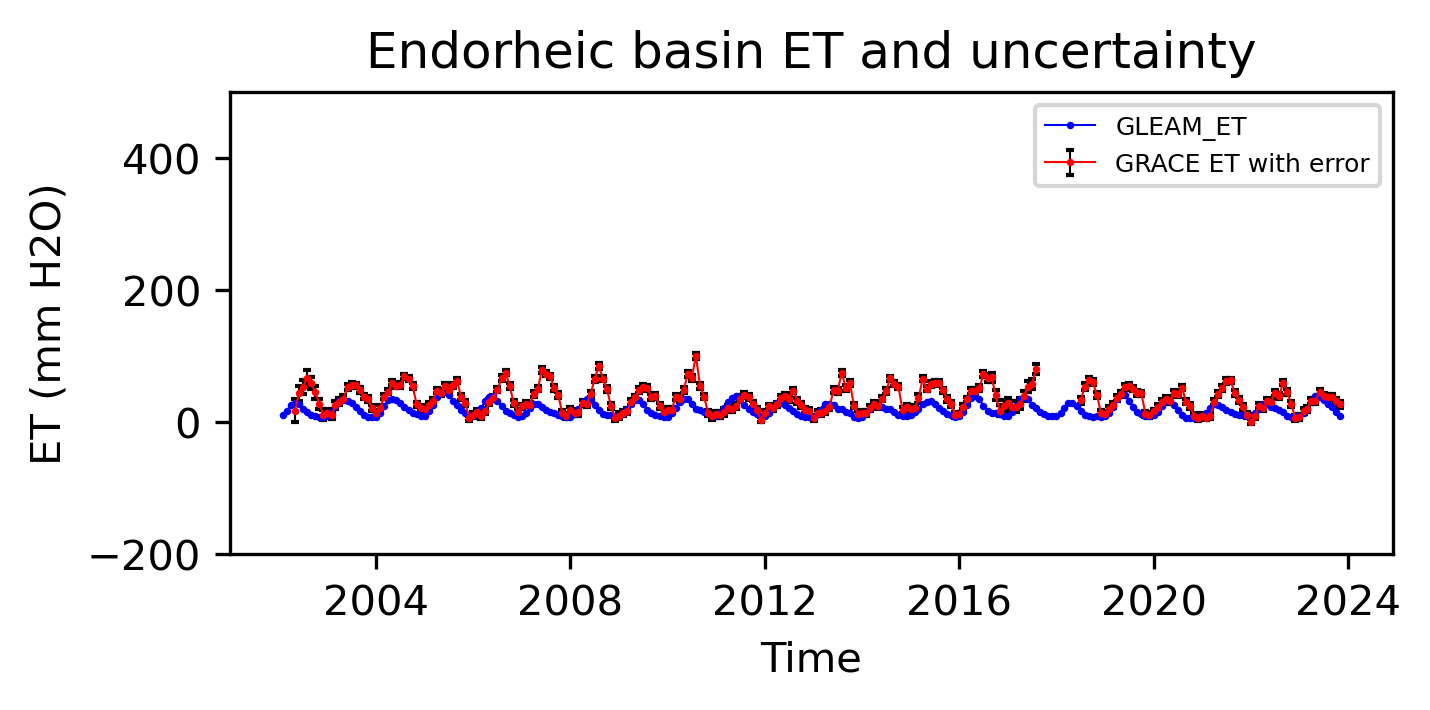

In [186]:
allbasinmask = read_basin("E:/01Project/04ET_assessment/04Basin_Boundary/Endorheic_GCS.shp")

# calculate the ds, pre, and ET
ds_basin,ds_error = cal_ds_error(allbasinmask)
pre_basin,pre_error = cal_pre_error(allbasinmask)

ET = pre_basin - ds_basin
ET_error = np.sqrt(ds_error**2+pre_error**2)

GLEAM_ET = read_gleam(allbasinmask)

# plot the baisn ET and error
plt.figure(figsize=(5,2),dpi=300)
plt.ylim(-200,500)
yerr = np.array(ET_error)
plt.errorbar(ET_basin.index, np.array(ET_basin), yerr=yerr,fmt='-or',linewidth=0.5,markersize =0.8, elinewidth=0.5,ecolor='k',capsize=1, label='GRACE ET with error')
plt.plot(GLEAM_ET, '-ob',linewidth=0.5,markersize =0.8,label='GLEAM_ET')
plt.legend(fontsize=6)
plt.xlabel('Time')
plt.ylabel('ET (mm H2O)')
plt.title('Endorheic basin ET and uncertainty')

In [119]:
GLEAM_ET1 = pd.DataFrame({'Date':GLEAM_ET.index,'GLEAM_ET':np.array(GLEAM_ET)})
GLEAM_ET1.to_excel("E:/01Project/04ET_assessment/07GLEAM_ET_excel/Endorheic_GLEAMET.xlsx", index=False)


In [187]:
ET_uncertian1 = pd.DataFrame({'Date':ET_error.index,'ET_error':np.array(ET_error)})
ET1 = pd.DataFrame({'Date':ET_basin.index,'ET':np.array(ET_basin)})
ds1 = pd.DataFrame({'Date':ds_basin.index,'dTWS':np.array(ds_basin)})
ds_error1 = pd.DataFrame({'Date':ds_error.index,'dTWS_error':np.array(ds_error)})
pre_average1 = pd.DataFrame({'Date':pre_basin.index,'PRE':np.array(pre_basin)})
pre_error1 = pd.DataFrame({'Date':pre_error.index,'PRE_error':np.array(pre_error)})

#merge_df = pd.merge(ET1, ET_uncertian1,ds1,ds_error1,pre_average1,pre_error1,runnoff_mm1, on='Date')
merge_df = pd.merge(ET1, ET_uncertian1, on='Date')
merge_df = pd.merge(merge_df,pre_average1, on='Date')
merge_df = pd.merge(merge_df,pre_error1, on='Date')
merge_df = pd.merge(merge_df,ds1, on='Date')
merge_df = pd.merge(merge_df,ds_error1, on='Date')
print(merge_df)
merge_df.to_excel("E:/01Project/04ET_assessment/05GRACE-based_ET/Endorheic_ET.xlsx", index=False)

          Date         ET   ET_error        PRE  PRE_error       dTWS  \
0   2002-05-01  17.422262  17.433777   9.241907   0.140033 -16.855133   
1   2002-06-01  43.722297  11.672523   5.705756   0.119818 -32.169975   
2   2002-07-01  53.202836  10.730492   8.248158   0.124160 -32.169975   
3   2002-08-01  67.499180  11.546663   2.560690   0.094626 -26.721388   
4   2002-09-01  59.267095   8.661951  15.750741   0.166888 -14.447241   
..         ...        ...        ...        ...        ...        ...   
255 2023-08-01  38.227423   4.435283  40.280043   0.735824 -29.343612   
256 2023-09-01  38.153325   4.414509  23.339011   0.559174 -17.839471   
257 2023-10-01  31.875023   4.558452  13.904617   0.428526   0.203547   
258 2023-11-01  26.777977   4.741327  20.294790   0.502505  19.927942   
259 2023-12-01        NaN   5.113837  30.455569   0.650547  39.897648   

     dTWS_error  
0     17.433214  
1     11.671908  
2     10.729773  
3     11.546275  
4      8.660343  
..          ...

In [411]:
print(np.mean(ET_error))

4.814004042029901


In [412]:
print(np.mean(pre_error))

0.37268228786611957


In [410]:
print(np.mean(ds_error))

4.910410328119861


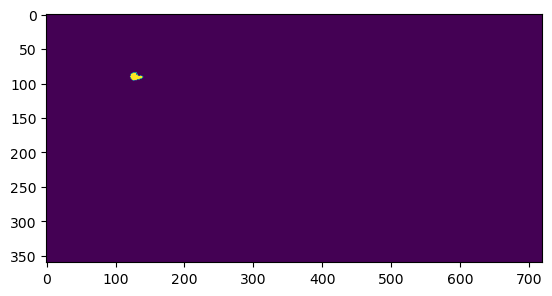

In [374]:
plt.imshow(allbasinmask)

In [368]:
np.sum(allbasinmask)

0.0

In [376]:
from geopandas import GeoDataFrame, GeoSeries
from shapely.geometry import Point, Polygon
import geopandas
import numpy as np
df = geopandas.read_file("E:/01Project/04ET_assessment/04Basin_Boundary/Endorheic.shp")
lon, lat = -179.875 + np.arange(1440)*0.25, 89.875 - np.arange(720)*0.25
llon, llat = np.meshgrid(lon,lat)
flon, flat = llon.flatten(), llat.flatten()
pts = GeoSeries([Point(x,y) for x,y in zip(flon,flat)])
in_map = np.array([pts.within(geom) for geom in df.geometry])

allbasinmask = np.zeros((360,720))

for i in range(len(in_map)):
    basinmask = in_map[i,:].reshape(720,1440).astype(int)
    basinmask = basinmask.reshape(360,2,720,2)
    basinmask = np.sum(np.sum(basinmask,axis=1),axis=-1)
    basinmask[basinmask>1] = 1
    allbasinmask = allbasinmask+basinmask

   Id  ORIG_FID                                           geometry
0   0         0  POLYGON ((-12345795.36 4194422.817, -12346259....


<Axes: >

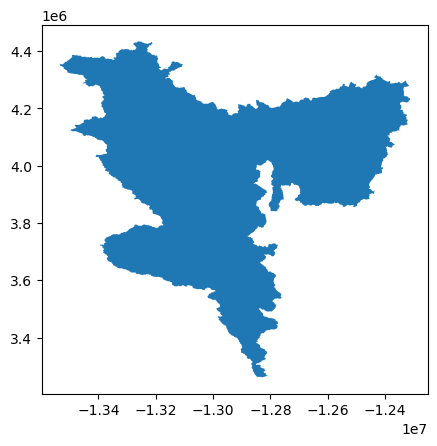

In [377]:
print(df.head())
df.plot()

In [372]:
np.sum(in_map)


0

In [280]:
import pandas as pd
df = pd.read_csv("E:/01Project/04ET_assessment/01USGS_runoff/BulkExport-08475000-20250107170359/08475000.csv",skiprows = 1)
df = df.iloc[:-1]
df['End of Interval (UTC-06:00)'] = pd.to_datetime(df['End of Interval (UTC-06:00)']).apply(lambda x: x.replace(day=1))
total_runoff = pd.Series([value for value in df['Value (ft^3/s)']],df['End of Interval (UTC-06:00)'])
total_runoff


End of Interval (UTC-06:00)
1991-01-01    127.20
1991-02-01    467.34
1991-03-01    169.22
1991-04-01    408.73
1991-05-01    965.60
               ...  
2024-08-01     83.07
2024-09-01    128.26
2024-10-01    595.37
2024-11-01    236.68
2024-12-01    164.24
Length: 408, dtype: float64

In [237]:
# Calculate the area-weighted averaged TWS in a basin    
var1= np.tile(area_weights[allbasinmask==1],(var_TWS.shape[0],1))
var2 = var_TWS[:,allbasinmask==1]
var1[np.isnan(var2)]=np.nan
mask_average = np.nansum(var1*var2,axis=1)/np.nansum(var1,axis=1)
    
# Calculate the area-weighted averaged TWS-error in a basin   
var3= np.tile(area_weights[allbasinmask==1],(uncertainty.shape[0],1))
var4 = uncertainty[:,allbasinmask==1]
var3[np.isnan(var4)]=np.nan
var5 = mascon*allbasinmask
var5 = var5.filled(np.nan)
new_var5 = var5.reshape((360*720))
    
mascon_uncertainty = np.zeros((uncertainty.shape[0]))
print(list(set(new_var5[:])))
for j in range(var_TWS.shape[0]):
    temp = 0
    for i in list(set(new_var5[:])):
        if i==0:
            continue
        temp = temp+(np.sum(area_weights[var5==i])**2)*(np.mean(uncertainty[j,var5==i])**2)/np.sum(area_weights[mascon==i])**2        
    mascon_uncertainty[j] = np.sqrt(temp)

mask_average = pd.Series(mask_average, date)
mask_average = mask_average.resample('MS').mean().interpolate('linear',limit=3,limit_area='inside')

mascon_uncertainty = pd.Series(mascon_uncertainty, date)
mascon_uncertainty = mascon_uncertainty.resample('MS').mean().interpolate('linear',limit=3,limit_area='inside')
ds,ds_error = central_diff(mask_average,mascon_uncertainty)



[0.0, 952.0, 856.0, 857.0, 953.0, 764.0, 765.0]


In [239]:
ds_error

2002-05-01    67.560803
2002-06-01    46.858129
2002-07-01    42.826107
2002-08-01    48.404317
2002-09-01    35.141929
                ...    
2024-05-01    26.923998
2024-06-01    32.304805
2024-07-01    38.766744
2024-08-01    47.415604
2024-09-01    58.678139
Freq: MS, Length: 269, dtype: float64

In [182]:
runnoff_snake1 = pd.DataFrame({'Date':runoff_mm.index,'Runoff_snake (cubic_feet_per_second)':np.array(runoff_snake)})
runnoff_clearwater1 = pd.DataFrame({'Date':runoff_mm.index,'Runoff_clearwater (cubic_feet_per_second)':np.array(runoff_clearwater)})
runnoff_feet1 = pd.DataFrame({'Date':runoff_mm.index,'Runoff_total (cubic_feet_per_second)':np.array(runoff_snake+runoff_clearwater)})
runnoff_mm1 = pd.DataFrame({'Date':runoff_mm.index,'Runoff_total (mm)':np.array(runoff_mm)})
#merge_df = pd.merge(ET1, ET_uncertian1,ds1,ds_error1,pre_average1,pre_error1,runnoff_mm1, on='Date')
merge_df = pd.merge(runnoff_mm1, runnoff_feet1, on='Date')
merge_df = pd.merge(merge_df, runnoff_snake1, on='Date')
merge_df = pd.merge(merge_df, runnoff_clearwater1, on='Date')

merge_df.to_excel("E:/01Project/04ET_assessment/Snake_river_runoff.xlsx", index=False)

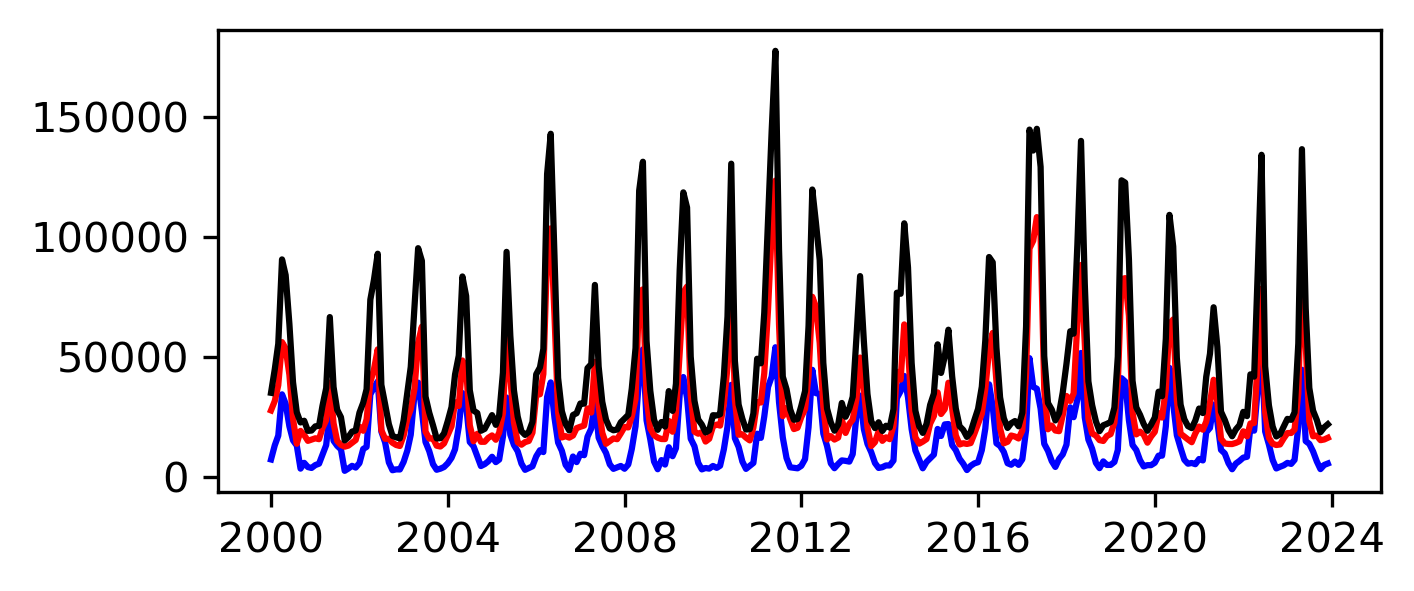

In [71]:
plt.figure(figsize=(5,2),dpi=300)
plt.plot(runoff_clearwater,'b')
plt.plot(runoff_snake,'r')
plt.plot(runoff_snake+runoff_clearwater,'k')


In [164]:
ET_uncertian1 = pd.DataFrame({'Date':ET_uncertian.index,'ET_error':np.array(ET_uncertian)})
ET1 = pd.DataFrame({'Date':ET.index,'ET':np.array(ET)})
ds1 = pd.DataFrame({'Date':ds.index,'dTWS':np.array(ds)})
ds_error1 = pd.DataFrame({'Date':ds_error.index,'dTWS_error':np.array(ds_error)})
pre_average1 = pd.DataFrame({'Date':pre_average.index,'PRE':np.array(pre_average)})
pre_error1 = pd.DataFrame({'Date':pre_error.index,'PRE_error':np.array(pre_error)})
runnoff_mm1 = pd.DataFrame({'Date':runoff_mm.index,'Runoff':np.array(runoff_mm)})
#merge_df = pd.merge(ET1, ET_uncertian1,ds1,ds_error1,pre_average1,pre_error1,runnoff_mm1, on='Date')
merge_df = pd.merge(ET1, ET_uncertian1, on='Date')
merge_df = pd.merge(merge_df,pre_average1, on='Date')
merge_df = pd.merge(merge_df,pre_error1, on='Date')
merge_df = pd.merge(merge_df,ds1, on='Date')
merge_df = pd.merge(merge_df,ds_error1, on='Date')
merge_df = pd.merge(merge_df,runnoff_mm1, on='Date')
merge_df.to_excel("E:/01Project/04ET_assessment/Snake_river_ET.xlsx", index=False)